# Experiment 1
Change epoch=10 
## Accuracy=0.81667

In [28]:
import os, io, torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
import numpy as np


def print_named_params(model):
  for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")


def load_filepaths(target_dir): 
  paths = []
  files = os.listdir(target_dir)
  for file in files:
    paths.append(f"{target_dir}/{file}")
  return paths


def prepare_data(target_dir):
    filepaths = []
    encoded_labels = []
    
    fpaths = load_filepaths(target_dir)
    
    for file in fpaths:
        if 'apple' in file:
            encoded_labels.append(0)
        elif 'banana' in file:
            encoded_labels.append(1)
        elif 'orange' in file:
            encoded_labels.append(2)
        else:
            encoded_labels.append(3)
            
    filepaths += fpaths
    
    return np.array(filepaths), torch.tensor(encoded_labels)
    


def load_images(filepaths):
  # Instantiate class to transform image to tensor
  transform = transforms.Compose([
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor = None

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    img_tensor = transform(image)

    if tensor is None:
      tensor = img_tensor.unsqueeze(0)  # First image
    else:
      tensor = torch.cat((tensor, img_tensor.unsqueeze(0)), dim=0)

  return tensor  # ✅ Correctly indented inside the function

def load_images(filepaths):
  transform = transforms.Compose([
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor_list = []

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    tensor_list.append(transform(image))

  return torch.stack(tensor_list)


class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # in_channels=1 because our image is grayscale (if color images, then in_channels=3 for RGB).
    # out_channels=16 means we have 16 filters, each filter of size 3x3x1.
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    
    # in_channels=16 because our out_channels=16 from previous layer.
    # out_channels=32 means we are using 32 filters, each filter of size 3x3x16,
    # in this layer.
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    
    # Max Pooling Layer: downsample by a factor of 2.
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Fully Connected Layer 1: input size = 7 * 7 * 32 (from feature maps), output size = 128.
    self.fc1 = nn.Linear(in_features= 32 * 16 * 16, out_features=128)
    
    # Fully Connected Layer 2: input size = 128, output size = 10 (for 10 output classes).
    self.fc2 = nn.Linear(in_features=128, out_features=4)

    # Activation function
    self.relu = nn.ReLU()

  def forward(self, x):
    #print(f"x.shape={x.shape}\n")

    # Apply convolution + ReLU + pooling
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    # Flatten the feature maps 
    x = x.view(x.size(0), -1)

    # Fully connected layers
    x = self.fc1(x)
    x = self.relu(x)
    
    # Output layer (no activation since we apply softmax in the loss function)
    x = self.fc2(x)
    
    return x


def test(model, filepaths, labels):
  batch_size = 64
  samples_tested = 0
  correct_preds = 0
  total_samples = len(filepaths)

  for i in range(0, total_samples, batch_size):
    batch_inputs = load_images(filepaths[i : i + batch_size])
    batch_labels = labels[i : i + batch_size]

    # Forward pass: coyympute predicted outputs
    outputs = model(batch_inputs)

    # Get probability-distributions
    probs = torch.softmax(outputs, dim=1)
    _, preds = torch.max(probs, dim=1)

    # Determine accuracy
    samples_tested += len(batch_labels)
    correct_preds += torch.sum(preds == batch_labels)
    accuracy = correct_preds / float(samples_tested)

    print(f"({samples_tested}/{total_samples}): Accuracy={accuracy:.5f}")


def train(model, criterion, optimizer, filepaths, labels):
  # our hyper-parameters for training
  n_epochs = 10
  batch_size = 64
  batch_count = 0

  for epoch in range(n_epochs):
    # For tracking and printing our training-progress
    samples_trained = 0
    run_loss = 0
    correct_preds = 0
    total_samples = len(filepaths) 

    permutation = torch.randperm(total_samples)
    for i in range(0, total_samples, batch_size):
      indices = permutation[i : i+batch_size]
      batch_inputs = load_images(filepaths[indices])
      batch_labels = labels[indices]

      # Forward pass: compute predicted outputs
      outputs = model(batch_inputs)

      # Compute loss
      loss = criterion(outputs, batch_labels)
      run_loss += loss.item()
      batch_count += 1

      # Backward pass and optimization step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Get probability-distributions
      probs = torch.softmax(outputs, dim=1)
      _, preds = torch.max(probs, dim=1)

      # Calculate some stats
      # samples_trained += len(indices)
      samples_trained += len(batch_labels)
      avg_loss = run_loss / batch_count

      correct_preds += torch.sum(preds == batch_labels) # compare predictions with labels
      accuracy = correct_preds / float(samples_trained) # cast to float to get "accuracy" in decimal 

      print(f"Epoch {epoch+1} " +
            f"({samples_trained}/{total_samples}): " +
            f"Loss={avg_loss:.5f}, Accuracy={accuracy:.5f}")



# Instantiate the model, define the loss function and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model 
dir_train = "C:/Users/Admin/OneDrive/Desktop/train" # place accordingly
filepaths, labels = prepare_data(dir_train)
train(model, criterion, optimizer, filepaths, labels)

# Test the model
dir_test = "C:/Users/Admin/OneDrive/Desktop/test"
filepaths, labels = prepare_data(dir_test)
test(model, filepaths, labels)


Epoch 1 (64/240): Loss=1.37269, Accuracy=0.31250
Epoch 1 (128/240): Loss=1.38271, Accuracy=0.37500
Epoch 1 (192/240): Loss=1.38744, Accuracy=0.36458
Epoch 1 (240/240): Loss=1.34543, Accuracy=0.35417
Epoch 2 (64/240): Loss=0.23570, Accuracy=0.35938
Epoch 2 (128/240): Loss=0.40532, Accuracy=0.39844
Epoch 2 (192/240): Loss=0.54222, Accuracy=0.36979
Epoch 2 (240/240): Loss=0.63848, Accuracy=0.41250
Epoch 3 (64/240): Loss=0.13561, Accuracy=0.29688
Epoch 3 (128/240): Loss=0.24953, Accuracy=0.28906
Epoch 3 (192/240): Loss=0.33374, Accuracy=0.34375
Epoch 3 (240/240): Loss=0.40571, Accuracy=0.35833
Epoch 4 (64/240): Loss=0.08692, Accuracy=0.54688
Epoch 4 (128/240): Loss=0.15871, Accuracy=0.61719
Epoch 4 (192/240): Loss=0.22287, Accuracy=0.62500
Epoch 4 (240/240): Loss=0.27620, Accuracy=0.64167
Epoch 5 (64/240): Loss=0.05278, Accuracy=0.67188
Epoch 5 (128/240): Loss=0.11243, Accuracy=0.58594
Epoch 5 (192/240): Loss=0.15280, Accuracy=0.60417
Epoch 5 (240/240): Loss=0.19111, Accuracy=0.62917
Epoch

# Experiment 2
#### Replace 
criterion = nn.CrossEntropyLoss() 
with 
#### Convert tensor to numpy array
labels_np = labels.numpy()
classes = np.unique(labels_np)

#### Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels_np)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

#### Apply weights to CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)
## Accuracy=0.65000

In [29]:
import os, io, torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

def print_named_params(model):
  for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")


def load_filepaths(target_dir): 
  paths = []
  files = os.listdir(target_dir)
  for file in files:
    paths.append(f"{target_dir}/{file}")
  return paths


def prepare_data(target_dir):
    filepaths = []
    encoded_labels = []
    
    fpaths = load_filepaths(target_dir)
    
    for file in fpaths:
        if 'apple' in file:
            encoded_labels.append(0)
        elif 'banana' in file:
            encoded_labels.append(1)
        elif 'orange' in file:
            encoded_labels.append(2)
        else:
            encoded_labels.append(3)
            
    filepaths += fpaths
    
    return np.array(filepaths), torch.tensor(encoded_labels)
    


def load_images(filepaths):
  # Instantiate class to transform image to tensor
  transform = transforms.Compose([
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor = None

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    img_tensor = transform(image)

    if tensor is None:
      tensor = img_tensor.unsqueeze(0)  # First image
    else:
      tensor = torch.cat((tensor, img_tensor.unsqueeze(0)), dim=0)

  return tensor  # ✅ Correctly indented inside the function

def load_images(filepaths):
  transform = transforms.Compose([
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor_list = []

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    tensor_list.append(transform(image))

  return torch.stack(tensor_list)


class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # in_channels=1 because our image is grayscale (if color images, then in_channels=3 for RGB).
    # out_channels=16 means we have 16 filters, each filter of size 3x3x1.
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    
    # in_channels=16 because our out_channels=16 from previous layer.
    # out_channels=32 means we are using 32 filters, each filter of size 3x3x16,
    # in this layer.
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    
    # Max Pooling Layer: downsample by a factor of 2.
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Fully Connected Layer 1: input size = 7 * 7 * 32 (from feature maps), output size = 128.
    self.fc1 = nn.Linear(in_features= 32 * 16 * 16, out_features=128)
    
    # Fully Connected Layer 2: input size = 128, output size = 10 (for 10 output classes).
    self.fc2 = nn.Linear(in_features=128, out_features=4)

    # Activation function
    self.relu = nn.ReLU()

  def forward(self, x):
    #print(f"x.shape={x.shape}\n")

    # Apply convolution + ReLU + pooling
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    # Flatten the feature maps 
    x = x.view(x.size(0), -1)

    # Fully connected layers
    x = self.fc1(x)
    x = self.relu(x)
    
    # Output layer (no activation since we apply softmax in the loss function)
    x = self.fc2(x)
    
    return x


def test(model, filepaths, labels):
  batch_size = 64
  samples_tested = 0
  correct_preds = 0
  total_samples = len(filepaths)

  for i in range(0, total_samples, batch_size):
    batch_inputs = load_images(filepaths[i : i + batch_size])
    batch_labels = labels[i : i + batch_size]

    # Forward pass: coyympute predicted outputs
    outputs = model(batch_inputs)

    # Get probability-distributions
    probs = torch.softmax(outputs, dim=1)
    _, preds = torch.max(probs, dim=1)

    # Determine accuracy
    samples_tested += len(batch_labels)
    correct_preds += torch.sum(preds == batch_labels)
    accuracy = correct_preds / float(samples_tested)

    print(f"({samples_tested}/{total_samples}): Accuracy={accuracy:.5f}")


def train(model, criterion, optimizer, filepaths, labels):
  # our hyper-parameters for training
  n_epochs = 10
  batch_size = 64
  batch_count = 0

  for epoch in range(n_epochs):
    # For tracking and printing our training-progress
    samples_trained = 0
    run_loss = 0
    correct_preds = 0
    total_samples = len(filepaths) 

    permutation = torch.randperm(total_samples)
    for i in range(0, total_samples, batch_size):
      indices = permutation[i : i+batch_size]
      batch_inputs = load_images(filepaths[indices])
      batch_labels = labels[indices]

      # Forward pass: compute predicted outputs
      outputs = model(batch_inputs)

      # Compute loss
      loss = criterion(outputs, batch_labels)
      run_loss += loss.item()
      batch_count += 1

      # Backward pass and optimization step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Get probability-distributions
      probs = torch.softmax(outputs, dim=1)
      _, preds = torch.max(probs, dim=1)

      # Calculate some stats
      # samples_trained += len(indices)
      samples_trained += len(batch_labels)
      avg_loss = run_loss / batch_count

      correct_preds += torch.sum(preds == batch_labels) # compare predictions with labels
      accuracy = correct_preds / float(samples_trained) # cast to float to get "accuracy" in decimal 

      print(f"Epoch {epoch+1} " +
            f"({samples_trained}/{total_samples}): " +
            f"Loss={avg_loss:.5f}, Accuracy={accuracy:.5f}")



# Instantiate the model, define the loss function and optimizer
model = SimpleCNN()

# Convert tensor to numpy array
labels_np = labels.numpy()
classes = np.unique(labels_np)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels_np)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Apply weights to CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model 
dir_train = "C:/Users/Admin/OneDrive/Desktop/train" # place accordingly
filepaths, labels = prepare_data(dir_train)
train(model, criterion, optimizer, filepaths, labels)

# Test the model
dir_test = "C:/Users/Admin/OneDrive/Desktop/test"
filepaths, labels = prepare_data(dir_test)
test(model, filepaths, labels)




Epoch 1 (64/240): Loss=1.38028, Accuracy=0.28125


C:\Users\Admin\anaconda3\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1 (128/240): Loss=1.62978, Accuracy=0.15625
Epoch 1 (192/240): Loss=1.56906, Accuracy=0.20312
Epoch 1 (240/240): Loss=1.50885, Accuracy=0.24583
Epoch 2 (64/240): Loss=0.27572, Accuracy=0.32812
Epoch 2 (128/240): Loss=0.45999, Accuracy=0.30469
Epoch 2 (192/240): Loss=0.58780, Accuracy=0.30729
Epoch 2 (240/240): Loss=0.68169, Accuracy=0.30833
Epoch 3 (64/240): Loss=0.14823, Accuracy=0.53125
Epoch 3 (128/240): Loss=0.26566, Accuracy=0.57031
Epoch 3 (192/240): Loss=0.35855, Accuracy=0.58854
Epoch 3 (240/240): Loss=0.43375, Accuracy=0.59167
Epoch 4 (64/240): Loss=0.09668, Accuracy=0.56250
Epoch 4 (128/240): Loss=0.18106, Accuracy=0.54688
Epoch 4 (192/240): Loss=0.24533, Accuracy=0.57812
Epoch 4 (240/240): Loss=0.30933, Accuracy=0.53333
Epoch 5 (64/240): Loss=0.07300, Accuracy=0.26562
Epoch 5 (128/240): Loss=0.13229, Accuracy=0.36719
Epoch 5 (192/240): Loss=0.18175, Accuracy=0.42708
Epoch 5 (240/240): Loss=0.22614, Accuracy=0.43750
Epoch 6 (64/240): Loss=0.05299, Accuracy=0.46875
Epoch

# Why Accuracy Might Drop After Adding Class Weights

## Balanced accuracy ≠ raw accuracy
CrossEntropyLoss(weight=...) forces the model to pay more attention to minority classes. This may reduce the overall accuracy if it previously predicted only the majority class correctly — but improves fairness across classes.

## Previous high accuracy was likely biased
Without class weights, the model may have been predicting the majority class for everything — yielding deceptively high accuracy.

Accuracy alone is misleading for imbalanced datasets
You should also track:

Precision / Recall / F1-score per class

Confusion matrix

# amend mislabel
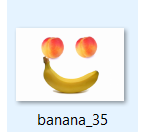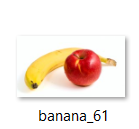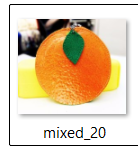

## Accuracy=0.81667

In [30]:
import os, io, torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
import numpy as np


def print_named_params(model):
  for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")


def load_filepaths(target_dir): 
  paths = []
  files = os.listdir(target_dir)
  for file in files:
    paths.append(f"{target_dir}/{file}")
  return paths


def prepare_data(target_dir):
    filepaths = []
    encoded_labels = []
    
    fpaths = load_filepaths(target_dir)
    
    for file in fpaths:
        if 'apple' in file:
            encoded_labels.append(0)
        elif 'banana' in file:
            encoded_labels.append(1)
        elif 'orange' in file:
            encoded_labels.append(2)
        else:
            encoded_labels.append(3)
            
    filepaths += fpaths
    
    return np.array(filepaths), torch.tensor(encoded_labels)
    


def load_images(filepaths):
  # Instantiate class to transform image to tensor
  transform = transforms.Compose([
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor = None

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    img_tensor = transform(image)

    if tensor is None:
      tensor = img_tensor.unsqueeze(0)  # First image
    else:
      tensor = torch.cat((tensor, img_tensor.unsqueeze(0)), dim=0)

  return tensor  # ✅ Correctly indented inside the function

def load_images(filepaths):
  transform = transforms.Compose([
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor_list = []

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    tensor_list.append(transform(image))

  return torch.stack(tensor_list)


class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # in_channels=1 because our image is grayscale (if color images, then in_channels=3 for RGB).
    # out_channels=16 means we have 16 filters, each filter of size 3x3x1.
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    
    # in_channels=16 because our out_channels=16 from previous layer.
    # out_channels=32 means we are using 32 filters, each filter of size 3x3x16,
    # in this layer.
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    
    # Max Pooling Layer: downsample by a factor of 2.
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Fully Connected Layer 1: input size = 7 * 7 * 32 (from feature maps), output size = 128.
    self.fc1 = nn.Linear(in_features= 32 * 16 * 16, out_features=128)
    
    # Fully Connected Layer 2: input size = 128, output size = 10 (for 10 output classes).
    self.fc2 = nn.Linear(in_features=128, out_features=4)

    # Activation function
    self.relu = nn.ReLU()

  def forward(self, x):
    #print(f"x.shape={x.shape}\n")

    # Apply convolution + ReLU + pooling
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    # Flatten the feature maps 
    x = x.view(x.size(0), -1)

    # Fully connected layers
    x = self.fc1(x)
    x = self.relu(x)
    
    # Output layer (no activation since we apply softmax in the loss function)
    x = self.fc2(x)
    
    return x


def test(model, filepaths, labels):
  batch_size = 64
  samples_tested = 0
  correct_preds = 0
  total_samples = len(filepaths)

  for i in range(0, total_samples, batch_size):
    batch_inputs = load_images(filepaths[i : i + batch_size])
    batch_labels = labels[i : i + batch_size]

    # Forward pass: coyympute predicted outputs
    outputs = model(batch_inputs)

    # Get probability-distributions
    probs = torch.softmax(outputs, dim=1)
    _, preds = torch.max(probs, dim=1)

    # Determine accuracy
    samples_tested += len(batch_labels)
    correct_preds += torch.sum(preds == batch_labels)
    accuracy = correct_preds / float(samples_tested)

    print(f"({samples_tested}/{total_samples}): Accuracy={accuracy:.5f}")


def train(model, criterion, optimizer, filepaths, labels):
  # our hyper-parameters for training
  n_epochs = 10
  batch_size = 64
  batch_count = 0

  for epoch in range(n_epochs):
    # For tracking and printing our training-progress
    samples_trained = 0
    run_loss = 0
    correct_preds = 0
    total_samples = len(filepaths) 

    permutation = torch.randperm(total_samples)
    for i in range(0, total_samples, batch_size):
      indices = permutation[i : i+batch_size]
      batch_inputs = load_images(filepaths[indices])
      batch_labels = labels[indices]

      # Forward pass: compute predicted outputs
      outputs = model(batch_inputs)

      # Compute loss
      loss = criterion(outputs, batch_labels)
      run_loss += loss.item()
      batch_count += 1

      # Backward pass and optimization step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Get probability-distributions
      probs = torch.softmax(outputs, dim=1)
      _, preds = torch.max(probs, dim=1)

      # Calculate some stats
      # samples_trained += len(indices)
      samples_trained += len(batch_labels)
      avg_loss = run_loss / batch_count

      correct_preds += torch.sum(preds == batch_labels) # compare predictions with labels
      accuracy = correct_preds / float(samples_trained) # cast to float to get "accuracy" in decimal 

      print(f"Epoch {epoch+1} " +
            f"({samples_trained}/{total_samples}): " +
            f"Loss={avg_loss:.5f}, Accuracy={accuracy:.5f}")



# Instantiate the model, define the loss function and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model 
dir_train = "C:/Users/Admin/OneDrive/Desktop/train" # place accordingly
filepaths, labels = prepare_data(dir_train)
train(model, criterion, optimizer, filepaths, labels)

# Test the model
dir_test = "C:/Users/Admin/OneDrive/Desktop/test"
filepaths, labels = prepare_data(dir_test)
test(model, filepaths, labels)

Epoch 1 (64/240): Loss=1.38236, Accuracy=0.25000
Epoch 1 (128/240): Loss=1.36684, Accuracy=0.27344
Epoch 1 (192/240): Loss=1.35022, Accuracy=0.29167
Epoch 1 (240/240): Loss=1.32399, Accuracy=0.28750
Epoch 2 (64/240): Loss=0.26512, Accuracy=0.26562
Epoch 2 (128/240): Loss=0.42779, Accuracy=0.34375
Epoch 2 (192/240): Loss=0.55055, Accuracy=0.30729
Epoch 2 (240/240): Loss=0.62999, Accuracy=0.30833
Epoch 3 (64/240): Loss=0.12906, Accuracy=0.54688
Epoch 3 (128/240): Loss=0.23254, Accuracy=0.58594
Epoch 3 (192/240): Loss=0.31576, Accuracy=0.55729
Epoch 3 (240/240): Loss=0.38899, Accuracy=0.54167
Epoch 4 (64/240): Loss=0.07436, Accuracy=0.73438
Epoch 4 (128/240): Loss=0.14235, Accuracy=0.64844
Epoch 4 (192/240): Loss=0.20244, Accuracy=0.61458
Epoch 4 (240/240): Loss=0.25513, Accuracy=0.63333
Epoch 5 (64/240): Loss=0.05959, Accuracy=0.62500
Epoch 5 (128/240): Loss=0.10677, Accuracy=0.70312
Epoch 5 (192/240): Loss=0.14615, Accuracy=0.72396
Epoch 5 (240/240): Loss=0.18264, Accuracy=0.71667
Epoch

# change n_epochs = 5, batch_size = 20

## Accuracy=0.85000

In [34]:
import os, io, torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
import numpy as np


def print_named_params(model):
  for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")


def load_filepaths(target_dir): 
  paths = []
  files = os.listdir(target_dir)
  for file in files:
    paths.append(f"{target_dir}/{file}")
  return paths


def prepare_data(target_dir):
    filepaths = []
    encoded_labels = []
    
    fpaths = load_filepaths(target_dir)
    
    for file in fpaths:
        if 'apple' in file:
            encoded_labels.append(0)
        elif 'banana' in file:
            encoded_labels.append(1)
        elif 'orange' in file:
            encoded_labels.append(2)
        else:
            encoded_labels.append(3)
            
    filepaths += fpaths
    
    return np.array(filepaths), torch.tensor(encoded_labels)
    


def load_images(filepaths):
  # Instantiate class to transform image to tensor
  transform = transforms.Compose([
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor = None

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    img_tensor = transform(image)

    if tensor is None:
      tensor = img_tensor.unsqueeze(0)  # First image
    else:
      tensor = torch.cat((tensor, img_tensor.unsqueeze(0)), dim=0)

  return tensor  # ✅ Correctly indented inside the function

def load_images(filepaths):
  transform = transforms.Compose([
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor_list = []

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    tensor_list.append(transform(image))

  return torch.stack(tensor_list)


class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # in_channels=1 because our image is grayscale (if color images, then in_channels=3 for RGB).
    # out_channels=16 means we have 16 filters, each filter of size 3x3x1.
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    
    # in_channels=16 because our out_channels=16 from previous layer.
    # out_channels=32 means we are using 32 filters, each filter of size 3x3x16,
    # in this layer.
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    
    # Max Pooling Layer: downsample by a factor of 2.
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Fully Connected Layer 1: input size = 7 * 7 * 32 (from feature maps), output size = 128.
    self.fc1 = nn.Linear(in_features= 32 * 16 * 16, out_features=128)
    
    # Fully Connected Layer 2: input size = 128, output size = 10 (for 10 output classes).
    self.fc2 = nn.Linear(in_features=128, out_features=4)

    # Activation function
    self.relu = nn.ReLU()

  def forward(self, x):
    #print(f"x.shape={x.shape}\n")

    # Apply convolution + ReLU + pooling
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    # Flatten the feature maps 
    x = x.view(x.size(0), -1)

    # Fully connected layers
    x = self.fc1(x)
    x = self.relu(x)
    
    # Output layer (no activation since we apply softmax in the loss function)
    x = self.fc2(x)
    
    return x


def test(model, filepaths, labels):
  batch_size = 64
  samples_tested = 0
  correct_preds = 0
  total_samples = len(filepaths)

  for i in range(0, total_samples, batch_size):
    batch_inputs = load_images(filepaths[i : i + batch_size])
    batch_labels = labels[i : i + batch_size]

    # Forward pass: coyympute predicted outputs
    outputs = model(batch_inputs)

    # Get probability-distributions
    probs = torch.softmax(outputs, dim=1)
    _, preds = torch.max(probs, dim=1)

    # Determine accuracy
    samples_tested += len(batch_labels)
    correct_preds += torch.sum(preds == batch_labels)
    accuracy = correct_preds / float(samples_tested)

    print(f"({samples_tested}/{total_samples}): Accuracy={accuracy:.5f}")


def train(model, criterion, optimizer, filepaths, labels):
  # our hyper-parameters for training
  n_epochs = 5
  batch_size = 20
  batch_count = 0

  for epoch in range(n_epochs):
    # For tracking and printing our training-progress
    samples_trained = 0
    run_loss = 0
    correct_preds = 0
    total_samples = len(filepaths) 

    permutation = torch.randperm(total_samples)
    for i in range(0, total_samples, batch_size):
      indices = permutation[i : i+batch_size]
      batch_inputs = load_images(filepaths[indices])
      batch_labels = labels[indices]

      # Forward pass: compute predicted outputs
      outputs = model(batch_inputs)

      # Compute loss
      loss = criterion(outputs, batch_labels)
      run_loss += loss.item()
      batch_count += 1

      # Backward pass and optimization step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Get probability-distributions
      probs = torch.softmax(outputs, dim=1)
      _, preds = torch.max(probs, dim=1)

      # Calculate some stats
      # samples_trained += len(indices)
      samples_trained += len(batch_labels)
      avg_loss = run_loss / batch_count

      correct_preds += torch.sum(preds == batch_labels) # compare predictions with labels
      accuracy = correct_preds / float(samples_trained) # cast to float to get "accuracy" in decimal 

      print(f"Epoch {epoch+1} " +
            f"({samples_trained}/{total_samples}): " +
            f"Loss={avg_loss:.5f}, Accuracy={accuracy:.5f}")



# Instantiate the model, define the loss function and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model 
dir_train = "C:/Users/Admin/OneDrive/Desktop/train" # place accordingly
filepaths, labels = prepare_data(dir_train)
train(model, criterion, optimizer, filepaths, labels)

# Test the model
dir_test = "C:/Users/Admin/OneDrive/Desktop/test"
filepaths, labels = prepare_data(dir_test)
test(model, filepaths, labels)

Epoch 1 (20/240): Loss=1.41395, Accuracy=0.05000
Epoch 1 (40/240): Loss=1.37965, Accuracy=0.17500
Epoch 1 (60/240): Loss=1.35207, Accuracy=0.23333
Epoch 1 (80/240): Loss=1.34107, Accuracy=0.23750
Epoch 1 (100/240): Loss=1.31819, Accuracy=0.25000
Epoch 1 (120/240): Loss=1.32536, Accuracy=0.24167
Epoch 1 (140/240): Loss=1.30071, Accuracy=0.25000
Epoch 1 (160/240): Loss=1.30656, Accuracy=0.27500
Epoch 1 (180/240): Loss=1.33491, Accuracy=0.27778
Epoch 1 (200/240): Loss=1.33126, Accuracy=0.31000
Epoch 1 (220/240): Loss=1.31029, Accuracy=0.33636
Epoch 1 (240/240): Loss=1.28809, Accuracy=0.36250
Epoch 2 (20/240): Loss=0.09176, Accuracy=0.50000
Epoch 2 (40/240): Loss=0.15324, Accuracy=0.57500
Epoch 2 (60/240): Loss=0.21218, Accuracy=0.51667
Epoch 2 (80/240): Loss=0.25395, Accuracy=0.52500
Epoch 2 (100/240): Loss=0.30861, Accuracy=0.50000
Epoch 2 (120/240): Loss=0.34277, Accuracy=0.55000
Epoch 2 (140/240): Loss=0.36871, Accuracy=0.60000
Epoch 2 (160/240): Loss=0.40246, Accuracy=0.61875
Epoch 2 

# change 
transforms.Resize((32, 32)),
in_features= 32 * 8 * 8

## Accuracy=0.85000

In [37]:
import os, io, torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
import numpy as np


def print_named_params(model):
  for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")


def load_filepaths(target_dir): 
  paths = []
  files = os.listdir(target_dir)
  for file in files:
    paths.append(f"{target_dir}/{file}")
  return paths


def prepare_data(target_dir):
    filepaths = []
    encoded_labels = []
    
    fpaths = load_filepaths(target_dir)
    
    for file in fpaths:
        if 'apple' in file:
            encoded_labels.append(0)
        elif 'banana' in file:
            encoded_labels.append(1)
        elif 'orange' in file:
            encoded_labels.append(2)
        else:
            encoded_labels.append(3)
            
    filepaths += fpaths
    
    return np.array(filepaths), torch.tensor(encoded_labels)
    


def load_images(filepaths):
  # Instantiate class to transform image to tensor
  transform = transforms.Compose([
      transforms.Resize((32, 32)),
      transforms.ToTensor()
  ])

  tensor = None

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    img_tensor = transform(image)

    if tensor is None:
      tensor = img_tensor.unsqueeze(0)  # First image
    else:
      tensor = torch.cat((tensor, img_tensor.unsqueeze(0)), dim=0)

  return tensor  # ✅ Correctly indented inside the function

def load_images(filepaths):
  transform = transforms.Compose([
      transforms.Resize((32, 32)),
      transforms.ToTensor()
  ])

  tensor_list = []

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    tensor_list.append(transform(image))

  return torch.stack(tensor_list)


class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # in_channels=1 because our image is grayscale (if color images, then in_channels=3 for RGB).
    # out_channels=16 means we have 16 filters, each filter of size 3x3x1.
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    
    # in_channels=16 because our out_channels=16 from previous layer.
    # out_channels=32 means we are using 32 filters, each filter of size 3x3x16,
    # in this layer.
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    
    # Max Pooling Layer: downsample by a factor of 2.
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Fully Connected Layer 1: input size = 7 * 7 * 32 (from feature maps), output size = 128.
    self.fc1 = nn.Linear(in_features= 32 * 8 * 8, out_features=128)
    
    # Fully Connected Layer 2: input size = 128, output size = 10 (for 10 output classes).
    self.fc2 = nn.Linear(in_features=128, out_features=4)

    # Activation function
    self.relu = nn.ReLU()

  def forward(self, x):
    #print(f"x.shape={x.shape}\n")

    # Apply convolution + ReLU + pooling
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    # Flatten the feature maps 
    x = x.view(x.size(0), -1)

    # Fully connected layers
    x = self.fc1(x)
    x = self.relu(x)
    
    # Output layer (no activation since we apply softmax in the loss function)
    x = self.fc2(x)
    
    return x


def test(model, filepaths, labels):
  batch_size = 64
  samples_tested = 0
  correct_preds = 0
  total_samples = len(filepaths)

  for i in range(0, total_samples, batch_size):
    batch_inputs = load_images(filepaths[i : i + batch_size])
    batch_labels = labels[i : i + batch_size]

    # Forward pass: coyympute predicted outputs
    outputs = model(batch_inputs)

    # Get probability-distributions
    probs = torch.softmax(outputs, dim=1)
    _, preds = torch.max(probs, dim=1)

    # Determine accuracy
    samples_tested += len(batch_labels)
    correct_preds += torch.sum(preds == batch_labels)
    accuracy = correct_preds / float(samples_tested)

    print(f"({samples_tested}/{total_samples}): Accuracy={accuracy:.5f}")


def train(model, criterion, optimizer, filepaths, labels):
  # our hyper-parameters for training
  n_epochs = 5
  batch_size = 20
  batch_count = 0

  for epoch in range(n_epochs):
    # For tracking and printing our training-progress
    samples_trained = 0
    run_loss = 0
    correct_preds = 0
    total_samples = len(filepaths) 

    permutation = torch.randperm(total_samples)
    for i in range(0, total_samples, batch_size):
      indices = permutation[i : i+batch_size]
      batch_inputs = load_images(filepaths[indices])
      batch_labels = labels[indices]

      # Forward pass: compute predicted outputs
      outputs = model(batch_inputs)

      # Compute loss
      loss = criterion(outputs, batch_labels)
      run_loss += loss.item()
      batch_count += 1

      # Backward pass and optimization step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Get probability-distributions
      probs = torch.softmax(outputs, dim=1)
      _, preds = torch.max(probs, dim=1)

      # Calculate some stats
      # samples_trained += len(indices)
      samples_trained += len(batch_labels)
      avg_loss = run_loss / batch_count

      correct_preds += torch.sum(preds == batch_labels) # compare predictions with labels
      accuracy = correct_preds / float(samples_trained) # cast to float to get "accuracy" in decimal 

      print(f"Epoch {epoch+1} " +
            f"({samples_trained}/{total_samples}): " +
            f"Loss={avg_loss:.5f}, Accuracy={accuracy:.5f}")



# Instantiate the model, define the loss function and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model 
dir_train = "C:/Users/Admin/OneDrive/Desktop/train" # place accordingly
filepaths, labels = prepare_data(dir_train)
train(model, criterion, optimizer, filepaths, labels)

# Test the model
dir_test = "C:/Users/Admin/OneDrive/Desktop/test"
filepaths, labels = prepare_data(dir_test)
test(model, filepaths, labels)

Epoch 1 (20/240): Loss=1.40111, Accuracy=0.10000
Epoch 1 (40/240): Loss=1.36969, Accuracy=0.22500
Epoch 1 (60/240): Loss=1.35008, Accuracy=0.30000
Epoch 1 (80/240): Loss=1.38721, Accuracy=0.26250
Epoch 1 (100/240): Loss=1.37264, Accuracy=0.27000
Epoch 1 (120/240): Loss=1.36533, Accuracy=0.29167
Epoch 1 (140/240): Loss=1.34267, Accuracy=0.32143
Epoch 1 (160/240): Loss=1.34765, Accuracy=0.31250
Epoch 1 (180/240): Loss=1.33191, Accuracy=0.32778
Epoch 1 (200/240): Loss=1.32249, Accuracy=0.34000
Epoch 1 (220/240): Loss=1.33171, Accuracy=0.32273
Epoch 1 (240/240): Loss=1.32567, Accuracy=0.31667
Epoch 2 (20/240): Loss=0.09121, Accuracy=0.40000
Epoch 2 (40/240): Loss=0.18063, Accuracy=0.50000
Epoch 2 (60/240): Loss=0.25234, Accuracy=0.48333
Epoch 2 (80/240): Loss=0.30619, Accuracy=0.48750
Epoch 2 (100/240): Loss=0.36380, Accuracy=0.45000
Epoch 2 (120/240): Loss=0.40754, Accuracy=0.48333
Epoch 2 (140/240): Loss=0.44464, Accuracy=0.47857
Epoch 2 (160/240): Loss=0.47845, Accuracy=0.50625
Epoch 2 

#   change
n_epochs = 10
  batch_size = 20
in_features= 32 * 8 * 8
transforms.Resize((32, 32)

## Accuracy=0.86667

In [38]:
import os, io, torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
import numpy as np


def print_named_params(model):
  for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")


def load_filepaths(target_dir): 
  paths = []
  files = os.listdir(target_dir)
  for file in files:
    paths.append(f"{target_dir}/{file}")
  return paths


def prepare_data(target_dir):
    filepaths = []
    encoded_labels = []
    
    fpaths = load_filepaths(target_dir)
    
    for file in fpaths:
        if 'apple' in file:
            encoded_labels.append(0)
        elif 'banana' in file:
            encoded_labels.append(1)
        elif 'orange' in file:
            encoded_labels.append(2)
        else:
            encoded_labels.append(3)
            
    filepaths += fpaths
    
    return np.array(filepaths), torch.tensor(encoded_labels)
    


def load_images(filepaths):
  # Instantiate class to transform image to tensor
  transform = transforms.Compose([
      transforms.Resize((32, 32)),
      transforms.ToTensor()
  ])

  tensor = None

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    img_tensor = transform(image)

    if tensor is None:
      tensor = img_tensor.unsqueeze(0)  # First image
    else:
      tensor = torch.cat((tensor, img_tensor.unsqueeze(0)), dim=0)

  return tensor  # ✅ Correctly indented inside the function

def load_images(filepaths):
  transform = transforms.Compose([
      transforms.Resize((32, 32)),
      transforms.ToTensor()
  ])

  tensor_list = []

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    tensor_list.append(transform(image))

  return torch.stack(tensor_list)


class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # in_channels=1 because our image is grayscale (if color images, then in_channels=3 for RGB).
    # out_channels=16 means we have 16 filters, each filter of size 3x3x1.
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    
    # in_channels=16 because our out_channels=16 from previous layer.
    # out_channels=32 means we are using 32 filters, each filter of size 3x3x16,
    # in this layer.
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    
    # Max Pooling Layer: downsample by a factor of 2.
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Fully Connected Layer 1: input size = 7 * 7 * 32 (from feature maps), output size = 128.
    self.fc1 = nn.Linear(in_features= 32 * 8 * 8, out_features=128)
    
    # Fully Connected Layer 2: input size = 128, output size = 10 (for 10 output classes).
    self.fc2 = nn.Linear(in_features=128, out_features=4)

    # Activation function
    self.relu = nn.ReLU()

  def forward(self, x):
    #print(f"x.shape={x.shape}\n")

    # Apply convolution + ReLU + pooling
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    # Flatten the feature maps 
    x = x.view(x.size(0), -1)

    # Fully connected layers
    x = self.fc1(x)
    x = self.relu(x)
    
    # Output layer (no activation since we apply softmax in the loss function)
    x = self.fc2(x)
    
    return x


def test(model, filepaths, labels):
  batch_size = 64
  samples_tested = 0
  correct_preds = 0
  total_samples = len(filepaths)

  for i in range(0, total_samples, batch_size):
    batch_inputs = load_images(filepaths[i : i + batch_size])
    batch_labels = labels[i : i + batch_size]

    # Forward pass: coyympute predicted outputs
    outputs = model(batch_inputs)

    # Get probability-distributions
    probs = torch.softmax(outputs, dim=1)
    _, preds = torch.max(probs, dim=1)

    # Determine accuracy
    samples_tested += len(batch_labels)
    correct_preds += torch.sum(preds == batch_labels)
    accuracy = correct_preds / float(samples_tested)

    print(f"({samples_tested}/{total_samples}): Accuracy={accuracy:.5f}")


def train(model, criterion, optimizer, filepaths, labels):
  # our hyper-parameters for training
  n_epochs = 10
  batch_size = 20
  batch_count = 0

  for epoch in range(n_epochs):
    # For tracking and printing our training-progress
    samples_trained = 0
    run_loss = 0
    correct_preds = 0
    total_samples = len(filepaths) 

    permutation = torch.randperm(total_samples)
    for i in range(0, total_samples, batch_size):
      indices = permutation[i : i+batch_size]
      batch_inputs = load_images(filepaths[indices])
      batch_labels = labels[indices]

      # Forward pass: compute predicted outputs
      outputs = model(batch_inputs)

      # Compute loss
      loss = criterion(outputs, batch_labels)
      run_loss += loss.item()
      batch_count += 1

      # Backward pass and optimization step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Get probability-distributions
      probs = torch.softmax(outputs, dim=1)
      _, preds = torch.max(probs, dim=1)

      # Calculate some stats
      # samples_trained += len(indices)
      samples_trained += len(batch_labels)
      avg_loss = run_loss / batch_count

      correct_preds += torch.sum(preds == batch_labels) # compare predictions with labels
      accuracy = correct_preds / float(samples_trained) # cast to float to get "accuracy" in decimal 

      print(f"Epoch {epoch+1} " +
            f"({samples_trained}/{total_samples}): " +
            f"Loss={avg_loss:.5f}, Accuracy={accuracy:.5f}")



# Instantiate the model, define the loss function and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model 
dir_train = "C:/Users/Admin/OneDrive/Desktop/train" # place accordingly
filepaths, labels = prepare_data(dir_train)
train(model, criterion, optimizer, filepaths, labels)

# Test the model
dir_test = "C:/Users/Admin/OneDrive/Desktop/test"
filepaths, labels = prepare_data(dir_test)
test(model, filepaths, labels)

Epoch 1 (20/240): Loss=1.37037, Accuracy=0.40000
Epoch 1 (40/240): Loss=1.33917, Accuracy=0.37500
Epoch 1 (60/240): Loss=1.36103, Accuracy=0.33333
Epoch 1 (80/240): Loss=1.35808, Accuracy=0.36250
Epoch 1 (100/240): Loss=1.33889, Accuracy=0.40000
Epoch 1 (120/240): Loss=1.33429, Accuracy=0.45000
Epoch 1 (140/240): Loss=1.33332, Accuracy=0.40714
Epoch 1 (160/240): Loss=1.33744, Accuracy=0.41250
Epoch 1 (180/240): Loss=1.31665, Accuracy=0.43889
Epoch 1 (200/240): Loss=1.32750, Accuracy=0.42500
Epoch 1 (220/240): Loss=1.31239, Accuracy=0.44091
Epoch 1 (240/240): Loss=1.30792, Accuracy=0.44167
Epoch 2 (20/240): Loss=0.08570, Accuracy=0.60000
Epoch 2 (40/240): Loss=0.17466, Accuracy=0.47500
Epoch 2 (60/240): Loss=0.25196, Accuracy=0.56667
Epoch 2 (80/240): Loss=0.30255, Accuracy=0.62500
Epoch 2 (100/240): Loss=0.34661, Accuracy=0.60000
Epoch 2 (120/240): Loss=0.39308, Accuracy=0.54167
Epoch 2 (140/240): Loss=0.45284, Accuracy=0.48571
Epoch 2 (160/240): Loss=0.48533, Accuracy=0.50625
Epoch 2 

# add
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((32, 32)),
## Accuracy=0.85000

In [39]:
import os, io, torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
import numpy as np


def print_named_params(model):
  for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")


def load_filepaths(target_dir): 
  paths = []
  files = os.listdir(target_dir)
  for file in files:
    paths.append(f"{target_dir}/{file}")
  return paths


def prepare_data(target_dir):
    filepaths = []
    encoded_labels = []
    
    fpaths = load_filepaths(target_dir)
    
    for file in fpaths:
        if 'apple' in file:
            encoded_labels.append(0)
        elif 'banana' in file:
            encoded_labels.append(1)
        elif 'orange' in file:
            encoded_labels.append(2)
        else:
            encoded_labels.append(3)
            
    filepaths += fpaths
    
    return np.array(filepaths), torch.tensor(encoded_labels)
    


def load_images(filepaths):
  # Instantiate class to transform image to tensor
  transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.Resize((32, 32)),
      transforms.ToTensor()
  ])

  tensor = None

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    img_tensor = transform(image)

    if tensor is None:
      tensor = img_tensor.unsqueeze(0)  # First image
    else:
      tensor = torch.cat((tensor, img_tensor.unsqueeze(0)), dim=0)

  return tensor  # ✅ Correctly indented inside the function

def load_images(filepaths):
  transform = transforms.Compose([
      transforms.Resize((32, 32)),
      transforms.ToTensor()
  ])

  tensor_list = []

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    tensor_list.append(transform(image))

  return torch.stack(tensor_list)


class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # in_channels=1 because our image is grayscale (if color images, then in_channels=3 for RGB).
    # out_channels=16 means we have 16 filters, each filter of size 3x3x1.
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    
    # in_channels=16 because our out_channels=16 from previous layer.
    # out_channels=32 means we are using 32 filters, each filter of size 3x3x16,
    # in this layer.
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    
    # Max Pooling Layer: downsample by a factor of 2.
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Fully Connected Layer 1: input size = 7 * 7 * 32 (from feature maps), output size = 128.
    self.fc1 = nn.Linear(in_features= 32 * 8 * 8, out_features=128)
    
    # Fully Connected Layer 2: input size = 128, output size = 10 (for 10 output classes).
    self.fc2 = nn.Linear(in_features=128, out_features=4)

    # Activation function
    self.relu = nn.ReLU()

  def forward(self, x):
    #print(f"x.shape={x.shape}\n")

    # Apply convolution + ReLU + pooling
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    # Flatten the feature maps 
    x = x.view(x.size(0), -1)

    # Fully connected layers
    x = self.fc1(x)
    x = self.relu(x)
    
    # Output layer (no activation since we apply softmax in the loss function)
    x = self.fc2(x)
    
    return x


def test(model, filepaths, labels):
  batch_size = 64
  samples_tested = 0
  correct_preds = 0
  total_samples = len(filepaths)

  for i in range(0, total_samples, batch_size):
    batch_inputs = load_images(filepaths[i : i + batch_size])
    batch_labels = labels[i : i + batch_size]

    # Forward pass: coyympute predicted outputs
    outputs = model(batch_inputs)

    # Get probability-distributions
    probs = torch.softmax(outputs, dim=1)
    _, preds = torch.max(probs, dim=1)

    # Determine accuracy
    samples_tested += len(batch_labels)
    correct_preds += torch.sum(preds == batch_labels)
    accuracy = correct_preds / float(samples_tested)

    print(f"({samples_tested}/{total_samples}): Accuracy={accuracy:.5f}")


def train(model, criterion, optimizer, filepaths, labels):
  # our hyper-parameters for training
  n_epochs = 10
  batch_size = 20
  batch_count = 0

  for epoch in range(n_epochs):
    # For tracking and printing our training-progress
    samples_trained = 0
    run_loss = 0
    correct_preds = 0
    total_samples = len(filepaths) 

    permutation = torch.randperm(total_samples)
    for i in range(0, total_samples, batch_size):
      indices = permutation[i : i+batch_size]
      batch_inputs = load_images(filepaths[indices])
      batch_labels = labels[indices]

      # Forward pass: compute predicted outputs
      outputs = model(batch_inputs)

      # Compute loss
      loss = criterion(outputs, batch_labels)
      run_loss += loss.item()
      batch_count += 1

      # Backward pass and optimization step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Get probability-distributions
      probs = torch.softmax(outputs, dim=1)
      _, preds = torch.max(probs, dim=1)

      # Calculate some stats
      # samples_trained += len(indices)
      samples_trained += len(batch_labels)
      avg_loss = run_loss / batch_count

      correct_preds += torch.sum(preds == batch_labels) # compare predictions with labels
      accuracy = correct_preds / float(samples_trained) # cast to float to get "accuracy" in decimal 

      print(f"Epoch {epoch+1} " +
            f"({samples_trained}/{total_samples}): " +
            f"Loss={avg_loss:.5f}, Accuracy={accuracy:.5f}")



# Instantiate the model, define the loss function and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model 
dir_train = "C:/Users/Admin/OneDrive/Desktop/train" # place accordingly
filepaths, labels = prepare_data(dir_train)
train(model, criterion, optimizer, filepaths, labels)

# Test the model
dir_test = "C:/Users/Admin/OneDrive/Desktop/test"
filepaths, labels = prepare_data(dir_test)
test(model, filepaths, labels)

Epoch 1 (20/240): Loss=1.38462, Accuracy=0.10000
Epoch 1 (40/240): Loss=1.35476, Accuracy=0.27500
Epoch 1 (60/240): Loss=1.33629, Accuracy=0.33333
Epoch 1 (80/240): Loss=1.37560, Accuracy=0.30000
Epoch 1 (100/240): Loss=1.36981, Accuracy=0.29000
Epoch 1 (120/240): Loss=1.39707, Accuracy=0.27500
Epoch 1 (140/240): Loss=1.37005, Accuracy=0.29286
Epoch 1 (160/240): Loss=1.36671, Accuracy=0.28750
Epoch 1 (180/240): Loss=1.35875, Accuracy=0.30000
Epoch 1 (200/240): Loss=1.34799, Accuracy=0.28500
Epoch 1 (220/240): Loss=1.34231, Accuracy=0.30455
Epoch 1 (240/240): Loss=1.33421, Accuracy=0.32917
Epoch 2 (20/240): Loss=0.10904, Accuracy=0.35000
Epoch 2 (40/240): Loss=0.18436, Accuracy=0.40000
Epoch 2 (60/240): Loss=0.26448, Accuracy=0.41667
Epoch 2 (80/240): Loss=0.32880, Accuracy=0.45000
Epoch 2 (100/240): Loss=0.38461, Accuracy=0.44000
Epoch 2 (120/240): Loss=0.43643, Accuracy=0.45000
Epoch 2 (140/240): Loss=0.48784, Accuracy=0.42143
Epoch 2 (160/240): Loss=0.51932, Accuracy=0.43750
Epoch 2 

# change
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((64, 64)),
      n_epochs = 25
## Accuracy=0.88333

In [41]:
import os, io, torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
import numpy as np


def print_named_params(model):
  for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")


def load_filepaths(target_dir): 
  paths = []
  files = os.listdir(target_dir)
  for file in files:
    paths.append(f"{target_dir}/{file}")
  return paths


def prepare_data(target_dir):
    filepaths = []
    encoded_labels = []
    
    fpaths = load_filepaths(target_dir)
    
    for file in fpaths:
        if 'apple' in file:
            encoded_labels.append(0)
        elif 'banana' in file:
            encoded_labels.append(1)
        elif 'orange' in file:
            encoded_labels.append(2)
        else:
            encoded_labels.append(3)
            
    filepaths += fpaths
    
    return np.array(filepaths), torch.tensor(encoded_labels)
    


def load_images(filepaths):
  # Instantiate class to transform image to tensor
  transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor = None

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    img_tensor = transform(image)

    if tensor is None:
      tensor = img_tensor.unsqueeze(0)  # First image
    else:
      tensor = torch.cat((tensor, img_tensor.unsqueeze(0)), dim=0)

  return tensor  # ✅ Correctly indented inside the function

def load_images(filepaths):
  transform = transforms.Compose([
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor_list = []

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    tensor_list.append(transform(image))

  return torch.stack(tensor_list)


class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # in_channels=1 because our image is grayscale (if color images, then in_channels=3 for RGB).
    # out_channels=16 means we have 16 filters, each filter of size 3x3x1.
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    
    # in_channels=16 because our out_channels=16 from previous layer.
    # out_channels=32 means we are using 32 filters, each filter of size 3x3x16,
    # in this layer.
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    
    # Max Pooling Layer: downsample by a factor of 2.
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Fully Connected Layer 1: input size = 7 * 7 * 32 (from feature maps), output size = 128.
    self.fc1 = nn.Linear(in_features= 32 * 16 * 16, out_features=128)
    
    # Fully Connected Layer 2: input size = 128, output size = 10 (for 10 output classes).
    self.fc2 = nn.Linear(in_features=128, out_features=4)

    # Activation function
    self.relu = nn.ReLU()

  def forward(self, x):
    #print(f"x.shape={x.shape}\n")

    # Apply convolution + ReLU + pooling
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    # Flatten the feature maps 
    x = x.view(x.size(0), -1)

    # Fully connected layers
    x = self.fc1(x)
    x = self.relu(x)
    
    # Output layer (no activation since we apply softmax in the loss function)
    x = self.fc2(x)
    
    return x


def test(model, filepaths, labels):
  batch_size = 64
  samples_tested = 0
  correct_preds = 0
  total_samples = len(filepaths)

  for i in range(0, total_samples, batch_size):
    batch_inputs = load_images(filepaths[i : i + batch_size])
    batch_labels = labels[i : i + batch_size]

    # Forward pass: coyympute predicted outputs
    outputs = model(batch_inputs)

    # Get probability-distributions
    probs = torch.softmax(outputs, dim=1)
    _, preds = torch.max(probs, dim=1)

    # Determine accuracy
    samples_tested += len(batch_labels)
    correct_preds += torch.sum(preds == batch_labels)
    accuracy = correct_preds / float(samples_tested)

    print(f"({samples_tested}/{total_samples}): Accuracy={accuracy:.5f}")


def train(model, criterion, optimizer, filepaths, labels):
  # our hyper-parameters for training
  n_epochs = 25
  batch_size = 64
  batch_count = 0

  for epoch in range(n_epochs):
    # For tracking and printing our training-progress
    samples_trained = 0
    run_loss = 0
    correct_preds = 0
    total_samples = len(filepaths) 

    permutation = torch.randperm(total_samples)
    for i in range(0, total_samples, batch_size):
      indices = permutation[i : i+batch_size]
      batch_inputs = load_images(filepaths[indices])
      batch_labels = labels[indices]

      # Forward pass: compute predicted outputs
      outputs = model(batch_inputs)

      # Compute loss
      loss = criterion(outputs, batch_labels)
      run_loss += loss.item()
      batch_count += 1

      # Backward pass and optimization step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Get probability-distributions
      probs = torch.softmax(outputs, dim=1)
      _, preds = torch.max(probs, dim=1)

      # Calculate some stats
      # samples_trained += len(indices)
      samples_trained += len(batch_labels)
      avg_loss = run_loss / batch_count

      correct_preds += torch.sum(preds == batch_labels) # compare predictions with labels
      accuracy = correct_preds / float(samples_trained) # cast to float to get "accuracy" in decimal 

      print(f"Epoch {epoch+1} " +
            f"({samples_trained}/{total_samples}): " +
            f"Loss={avg_loss:.5f}, Accuracy={accuracy:.5f}")



# Instantiate the model, define the loss function and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model 
dir_train = "C:/Users/Admin/OneDrive/Desktop/train" # place accordingly
filepaths, labels = prepare_data(dir_train)
train(model, criterion, optimizer, filepaths, labels)

# Test the model
dir_test = "C:/Users/Admin/OneDrive/Desktop/test"
filepaths, labels = prepare_data(dir_test)
test(model, filepaths, labels)


Epoch 1 (64/240): Loss=1.38698, Accuracy=0.23438
Epoch 1 (128/240): Loss=1.37738, Accuracy=0.25000
Epoch 1 (192/240): Loss=1.35690, Accuracy=0.25521
Epoch 1 (240/240): Loss=1.33606, Accuracy=0.27083
Epoch 2 (64/240): Loss=0.24350, Accuracy=0.26562
Epoch 2 (128/240): Loss=0.41169, Accuracy=0.37500
Epoch 2 (192/240): Loss=0.53130, Accuracy=0.40104
Epoch 2 (240/240): Loss=0.60937, Accuracy=0.45000
Epoch 3 (64/240): Loss=0.12319, Accuracy=0.76562
Epoch 3 (128/240): Loss=0.22034, Accuracy=0.71875
Epoch 3 (192/240): Loss=0.29357, Accuracy=0.74479
Epoch 3 (240/240): Loss=0.35452, Accuracy=0.73333
Epoch 4 (64/240): Loss=0.07371, Accuracy=0.75000
Epoch 4 (128/240): Loss=0.12986, Accuracy=0.74219
Epoch 4 (192/240): Loss=0.18020, Accuracy=0.74479
Epoch 4 (240/240): Loss=0.21927, Accuracy=0.74167
Epoch 5 (64/240): Loss=0.04350, Accuracy=0.71875
Epoch 5 (128/240): Loss=0.07530, Accuracy=0.77344
Epoch 5 (192/240): Loss=0.10925, Accuracy=0.77083
Epoch 5 (240/240): Loss=0.14000, Accuracy=0.77083
Epoch

# change
transforms.RandomHorizontalFlip(),
transforms.RandomRotation(10),
transforms.Resize((64, 64)),
  n_epochs = 50
## Accuracy=0.86667¶

In [42]:
import os, io, torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
import numpy as np


def print_named_params(model):
  for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")


def load_filepaths(target_dir): 
  paths = []
  files = os.listdir(target_dir)
  for file in files:
    paths.append(f"{target_dir}/{file}")
  return paths


def prepare_data(target_dir):
    filepaths = []
    encoded_labels = []
    
    fpaths = load_filepaths(target_dir)
    
    for file in fpaths:
        if 'apple' in file:
            encoded_labels.append(0)
        elif 'banana' in file:
            encoded_labels.append(1)
        elif 'orange' in file:
            encoded_labels.append(2)
        else:
            encoded_labels.append(3)
            
    filepaths += fpaths
    
    return np.array(filepaths), torch.tensor(encoded_labels)
    


def load_images(filepaths):
  # Instantiate class to transform image to tensor
  transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor = None

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    img_tensor = transform(image)

    if tensor is None:
      tensor = img_tensor.unsqueeze(0)  # First image
    else:
      tensor = torch.cat((tensor, img_tensor.unsqueeze(0)), dim=0)

  return tensor  # ✅ Correctly indented inside the function

def load_images(filepaths):
  transform = transforms.Compose([
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor_list = []

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    tensor_list.append(transform(image))

  return torch.stack(tensor_list)


class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # in_channels=1 because our image is grayscale (if color images, then in_channels=3 for RGB).
    # out_channels=16 means we have 16 filters, each filter of size 3x3x1.
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    
    # in_channels=16 because our out_channels=16 from previous layer.
    # out_channels=32 means we are using 32 filters, each filter of size 3x3x16,
    # in this layer.
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    
    # Max Pooling Layer: downsample by a factor of 2.
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Fully Connected Layer 1: input size = 7 * 7 * 32 (from feature maps), output size = 128.
    self.fc1 = nn.Linear(in_features= 32 * 16 * 16, out_features=128)
    
    # Fully Connected Layer 2: input size = 128, output size = 10 (for 10 output classes).
    self.fc2 = nn.Linear(in_features=128, out_features=4)

    # Activation function
    self.relu = nn.ReLU()

  def forward(self, x):
    #print(f"x.shape={x.shape}\n")

    # Apply convolution + ReLU + pooling
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    # Flatten the feature maps 
    x = x.view(x.size(0), -1)

    # Fully connected layers
    x = self.fc1(x)
    x = self.relu(x)
    
    # Output layer (no activation since we apply softmax in the loss function)
    x = self.fc2(x)
    
    return x


def test(model, filepaths, labels):
  batch_size = 64
  samples_tested = 0
  correct_preds = 0
  total_samples = len(filepaths)

  for i in range(0, total_samples, batch_size):
    batch_inputs = load_images(filepaths[i : i + batch_size])
    batch_labels = labels[i : i + batch_size]

    # Forward pass: coyympute predicted outputs
    outputs = model(batch_inputs)

    # Get probability-distributions
    probs = torch.softmax(outputs, dim=1)
    _, preds = torch.max(probs, dim=1)

    # Determine accuracy
    samples_tested += len(batch_labels)
    correct_preds += torch.sum(preds == batch_labels)
    accuracy = correct_preds / float(samples_tested)

    print(f"({samples_tested}/{total_samples}): Accuracy={accuracy:.5f}")


def train(model, criterion, optimizer, filepaths, labels):
  # our hyper-parameters for training
  n_epochs = 50
  batch_size = 64
  batch_count = 0

  for epoch in range(n_epochs):
    # For tracking and printing our training-progress
    samples_trained = 0
    run_loss = 0
    correct_preds = 0
    total_samples = len(filepaths) 

    permutation = torch.randperm(total_samples)
    for i in range(0, total_samples, batch_size):
      indices = permutation[i : i+batch_size]
      batch_inputs = load_images(filepaths[indices])
      batch_labels = labels[indices]

      # Forward pass: compute predicted outputs
      outputs = model(batch_inputs)

      # Compute loss
      loss = criterion(outputs, batch_labels)
      run_loss += loss.item()
      batch_count += 1

      # Backward pass and optimization step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Get probability-distributions
      probs = torch.softmax(outputs, dim=1)
      _, preds = torch.max(probs, dim=1)

      # Calculate some stats
      # samples_trained += len(indices)
      samples_trained += len(batch_labels)
      avg_loss = run_loss / batch_count

      correct_preds += torch.sum(preds == batch_labels) # compare predictions with labels
      accuracy = correct_preds / float(samples_trained) # cast to float to get "accuracy" in decimal 

      print(f"Epoch {epoch+1} " +
            f"({samples_trained}/{total_samples}): " +
            f"Loss={avg_loss:.5f}, Accuracy={accuracy:.5f}")



# Instantiate the model, define the loss function and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model 
dir_train = "C:/Users/Admin/OneDrive/Desktop/train" # place accordingly
filepaths, labels = prepare_data(dir_train)
train(model, criterion, optimizer, filepaths, labels)

# Test the model
dir_test = "C:/Users/Admin/OneDrive/Desktop/test"
filepaths, labels = prepare_data(dir_test)
test(model, filepaths, labels)


Epoch 1 (64/240): Loss=1.39501, Accuracy=0.07812
Epoch 1 (128/240): Loss=1.37246, Accuracy=0.17969
Epoch 1 (192/240): Loss=1.32694, Accuracy=0.21354
Epoch 1 (240/240): Loss=1.33185, Accuracy=0.27500
Epoch 2 (64/240): Loss=0.25877, Accuracy=0.51562
Epoch 2 (128/240): Loss=0.41429, Accuracy=0.54688
Epoch 2 (192/240): Loss=0.53060, Accuracy=0.55208
Epoch 2 (240/240): Loss=0.62291, Accuracy=0.52500
Epoch 3 (64/240): Loss=0.13836, Accuracy=0.67188
Epoch 3 (128/240): Loss=0.23447, Accuracy=0.71094
Epoch 3 (192/240): Loss=0.31484, Accuracy=0.68229
Epoch 3 (240/240): Loss=0.37245, Accuracy=0.71250
Epoch 4 (64/240): Loss=0.07309, Accuracy=0.81250
Epoch 4 (128/240): Loss=0.13454, Accuracy=0.75781
Epoch 4 (192/240): Loss=0.19662, Accuracy=0.71875
Epoch 4 (240/240): Loss=0.23485, Accuracy=0.72917
Epoch 5 (64/240): Loss=0.05736, Accuracy=0.60938
Epoch 5 (128/240): Loss=0.09306, Accuracy=0.68750
Epoch 5 (192/240): Loss=0.12621, Accuracy=0.72396
Epoch 5 (240/240): Loss=0.15454, Accuracy=0.74583
Epoch

Epoch 41 (240/240): Loss=0.00023, Accuracy=1.00000
Epoch 42 (64/240): Loss=0.00004, Accuracy=1.00000
Epoch 42 (128/240): Loss=0.00009, Accuracy=1.00000
Epoch 42 (192/240): Loss=0.00012, Accuracy=1.00000
Epoch 42 (240/240): Loss=0.00020, Accuracy=1.00000
Epoch 43 (64/240): Loss=0.00006, Accuracy=1.00000
Epoch 43 (128/240): Loss=0.00009, Accuracy=1.00000
Epoch 43 (192/240): Loss=0.00013, Accuracy=1.00000
Epoch 43 (240/240): Loss=0.00018, Accuracy=1.00000
Epoch 44 (64/240): Loss=0.00004, Accuracy=1.00000
Epoch 44 (128/240): Loss=0.00011, Accuracy=1.00000
Epoch 44 (192/240): Loss=0.00013, Accuracy=1.00000
Epoch 44 (240/240): Loss=0.00016, Accuracy=1.00000
Epoch 45 (64/240): Loss=0.00005, Accuracy=1.00000
Epoch 45 (128/240): Loss=0.00008, Accuracy=1.00000
Epoch 45 (192/240): Loss=0.00012, Accuracy=1.00000
Epoch 45 (240/240): Loss=0.00014, Accuracy=1.00000
Epoch 46 (64/240): Loss=0.00005, Accuracy=1.00000
Epoch 46 (128/240): Loss=0.00008, Accuracy=1.00000
Epoch 46 (192/240): Loss=0.00013, Ac

# change
transforms.RandomHorizontalFlip(),
transforms.RandomRotation(10),
transforms.Resize((64, 64)),
n_epochs = 30

## Accuracy=0.86667

In [44]:
import os, io, torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
import numpy as np


def print_named_params(model):
  for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")


def load_filepaths(target_dir): 
  paths = []
  files = os.listdir(target_dir)
  for file in files:
    paths.append(f"{target_dir}/{file}")
  return paths


def prepare_data(target_dir):
    filepaths = []
    encoded_labels = []
    
    fpaths = load_filepaths(target_dir)
    
    for file in fpaths:
        if 'apple' in file:
            encoded_labels.append(0)
        elif 'banana' in file:
            encoded_labels.append(1)
        elif 'orange' in file:
            encoded_labels.append(2)
        else:
            encoded_labels.append(3)
            
    filepaths += fpaths
    
    return np.array(filepaths), torch.tensor(encoded_labels)
    


def load_images(filepaths):
  # Instantiate class to transform image to tensor
  transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor = None

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    img_tensor = transform(image)

    if tensor is None:
      tensor = img_tensor.unsqueeze(0)  # First image
    else:
      tensor = torch.cat((tensor, img_tensor.unsqueeze(0)), dim=0)

  return tensor  # ✅ Correctly indented inside the function

def load_images(filepaths):
  transform = transforms.Compose([
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor_list = []

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    tensor_list.append(transform(image))

  return torch.stack(tensor_list)


class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # in_channels=1 because our image is grayscale (if color images, then in_channels=3 for RGB).
    # out_channels=16 means we have 16 filters, each filter of size 3x3x1.
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    
    # in_channels=16 because our out_channels=16 from previous layer.
    # out_channels=32 means we are using 32 filters, each filter of size 3x3x16,
    # in this layer.
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    
    # Max Pooling Layer: downsample by a factor of 2.
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Fully Connected Layer 1: input size = 7 * 7 * 32 (from feature maps), output size = 128.
    self.fc1 = nn.Linear(in_features= 32 * 16 * 16, out_features=128)
    
    # Fully Connected Layer 2: input size = 128, output size = 10 (for 10 output classes).
    self.fc2 = nn.Linear(in_features=128, out_features=4)

    # Activation function
    self.relu = nn.ReLU()

  def forward(self, x):
    #print(f"x.shape={x.shape}\n")

    # Apply convolution + ReLU + pooling
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    # Flatten the feature maps 
    x = x.view(x.size(0), -1)

    # Fully connected layers
    x = self.fc1(x)
    x = self.relu(x)
    
    # Output layer (no activation since we apply softmax in the loss function)
    x = self.fc2(x)
    
    return x


def test(model, filepaths, labels):
  batch_size = 64
  samples_tested = 0
  correct_preds = 0
  total_samples = len(filepaths)

  for i in range(0, total_samples, batch_size):
    batch_inputs = load_images(filepaths[i : i + batch_size])
    batch_labels = labels[i : i + batch_size]

    # Forward pass: coyympute predicted outputs
    outputs = model(batch_inputs)

    # Get probability-distributions
    probs = torch.softmax(outputs, dim=1)
    _, preds = torch.max(probs, dim=1)

    # Determine accuracy
    samples_tested += len(batch_labels)
    correct_preds += torch.sum(preds == batch_labels)
    accuracy = correct_preds / float(samples_tested)

    print(f"({samples_tested}/{total_samples}): Accuracy={accuracy:.5f}")


def train(model, criterion, optimizer, filepaths, labels):
  # our hyper-parameters for training
  n_epochs = 30
  batch_size = 64
  batch_count = 0

  for epoch in range(n_epochs):
    # For tracking and printing our training-progress
    samples_trained = 0
    run_loss = 0
    correct_preds = 0
    total_samples = len(filepaths) 

    permutation = torch.randperm(total_samples)
    for i in range(0, total_samples, batch_size):
      indices = permutation[i : i+batch_size]
      batch_inputs = load_images(filepaths[indices])
      batch_labels = labels[indices]

      # Forward pass: compute predicted outputs
      outputs = model(batch_inputs)

      # Compute loss
      loss = criterion(outputs, batch_labels)
      run_loss += loss.item()
      batch_count += 1

      # Backward pass and optimization step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Get probability-distributions
      probs = torch.softmax(outputs, dim=1)
      _, preds = torch.max(probs, dim=1)

      # Calculate some stats
      # samples_trained += len(indices)
      samples_trained += len(batch_labels)
      avg_loss = run_loss / batch_count

      correct_preds += torch.sum(preds == batch_labels) # compare predictions with labels
      accuracy = correct_preds / float(samples_trained) # cast to float to get "accuracy" in decimal 

      print(f"Epoch {epoch+1} " +
            f"({samples_trained}/{total_samples}): " +
            f"Loss={avg_loss:.5f}, Accuracy={accuracy:.5f}")



# Instantiate the model, define the loss function and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model 
dir_train = "C:/Users/Admin/OneDrive/Desktop/train" # place accordingly
filepaths, labels = prepare_data(dir_train)
train(model, criterion, optimizer, filepaths, labels)

# Test the model
dir_test = "C:/Users/Admin/OneDrive/Desktop/test"
filepaths, labels = prepare_data(dir_test)
test(model, filepaths, labels)

Epoch 1 (64/240): Loss=1.37349, Accuracy=0.28125
Epoch 1 (128/240): Loss=1.48287, Accuracy=0.24219
Epoch 1 (192/240): Loss=1.40473, Accuracy=0.29167
Epoch 1 (240/240): Loss=1.40478, Accuracy=0.28750
Epoch 2 (64/240): Loss=0.26327, Accuracy=0.29688
Epoch 2 (128/240): Loss=0.43856, Accuracy=0.27344
Epoch 2 (192/240): Loss=0.56411, Accuracy=0.29688
Epoch 2 (240/240): Loss=0.66281, Accuracy=0.27500
Epoch 3 (64/240): Loss=0.14860, Accuracy=0.25000
Epoch 3 (128/240): Loss=0.25828, Accuracy=0.40625
Epoch 3 (192/240): Loss=0.35286, Accuracy=0.46354
Epoch 3 (240/240): Loss=0.42725, Accuracy=0.51250
Epoch 4 (64/240): Loss=0.09450, Accuracy=0.54688
Epoch 4 (128/240): Loss=0.17374, Accuracy=0.65625
Epoch 4 (192/240): Loss=0.24495, Accuracy=0.66667
Epoch 4 (240/240): Loss=0.30466, Accuracy=0.69167
Epoch 5 (64/240): Loss=0.06832, Accuracy=0.70312
Epoch 5 (128/240): Loss=0.13225, Accuracy=0.69531
Epoch 5 (192/240): Loss=0.18370, Accuracy=0.70833
Epoch 5 (240/240): Loss=0.22452, Accuracy=0.71667
Epoch

## add dropout layer
in SimpleCNN added

    self.dropout = nn.Dropout(p=0.3)  # Dropout with 30% probability
    
in def forward added

    x = self.dropout(x) # apply dropout during training
## Accuracy=0.90000

In [13]:
import os, io, torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
import numpy as np


def print_named_params(model):
  for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")


def load_filepaths(target_dir): 
  paths = []
  files = os.listdir(target_dir)
  for file in files:
    paths.append(f"{target_dir}/{file}")
  return paths


def prepare_data(target_dir):
    filepaths = []
    encoded_labels = []
    
    fpaths = load_filepaths(target_dir)
    
    for file in fpaths:
        if 'apple' in file:
            encoded_labels.append(0)
        elif 'banana' in file:
            encoded_labels.append(1)
        elif 'orange' in file:
            encoded_labels.append(2)
        else:
            encoded_labels.append(3)
            
    filepaths += fpaths
    
    return np.array(filepaths), torch.tensor(encoded_labels)
    


def load_images(filepaths):
  # Instantiate class to transform image to tensor
  transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor = None

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    img_tensor = transform(image)

    if tensor is None:
      tensor = img_tensor.unsqueeze(0)  # First image
    else:
      tensor = torch.cat((tensor, img_tensor.unsqueeze(0)), dim=0)

  return tensor  # ✅ Correctly indented inside the function

def load_images(filepaths):
  transform = transforms.Compose([
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor_list = []

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    tensor_list.append(transform(image))

  return torch.stack(tensor_list)


class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # in_channels=1 because our image is grayscale (if color images, then in_channels=3 for RGB).
    # out_channels=16 means we have 16 filters, each filter of size 3x3x1.
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    
    # in_channels=16 because our out_channels=16 from previous layer.
    # out_channels=32 means we are using 32 filters, each filter of size 3x3x16,
    # in this layer.
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    
    # Max Pooling Layer: downsample by a factor of 2.
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Fully Connected Layer 1: input size = 7 * 7 * 32 (from feature maps), output size = 128.
    self.fc1 = nn.Linear(in_features= 32 * 16 * 16, out_features=128)
    
    self.dropout = nn.Dropout(p=0.3)  # Dropout with 30% probability
    
    # Fully Connected Layer 2: input size = 128, output size = 10 (for 10 output classes).
    self.fc2 = nn.Linear(in_features=128, out_features=4)

    # Activation function
    self.relu = nn.ReLU()

  def forward(self, x):
    #print(f"x.shape={x.shape}\n")

    # Apply convolution + ReLU + pooling
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    # Flatten the feature maps 
    x = x.view(x.size(0), -1)

    # Fully connected layers
    x = self.fc1(x)
    x = self.relu(x)
    
    x = self.dropout(x) # apply dropout during training
    
    # Output layer (no activation since we apply softmax in the loss function)
    x = self.fc2(x)
    
    return x


def test(model, filepaths, labels):
  batch_size = 64
  samples_tested = 0
  correct_preds = 0
  total_samples = len(filepaths)

  for i in range(0, total_samples, batch_size):
    batch_inputs = load_images(filepaths[i : i + batch_size])
    batch_labels = labels[i : i + batch_size]

    # Forward pass: coyympute predicted outputs
    outputs = model(batch_inputs)

    # Get probability-distributions
    probs = torch.softmax(outputs, dim=1)
    _, preds = torch.max(probs, dim=1)

    # Determine accuracy
    samples_tested += len(batch_labels)
    correct_preds += torch.sum(preds == batch_labels)
    accuracy = correct_preds / float(samples_tested)

    print(f"({samples_tested}/{total_samples}): Accuracy={accuracy:.5f}")


def train(model, criterion, optimizer, filepaths, labels):
  # our hyper-parameters for training
  n_epochs = 30
  batch_size = 64
  batch_count = 0

  for epoch in range(n_epochs):
    # For tracking and printing our training-progress
    samples_trained = 0
    run_loss = 0
    correct_preds = 0
    total_samples = len(filepaths) 

    permutation = torch.randperm(total_samples)
    for i in range(0, total_samples, batch_size):
      indices = permutation[i : i+batch_size]
      batch_inputs = load_images(filepaths[indices])
      batch_labels = labels[indices]

      # Forward pass: compute predicted outputs
      outputs = model(batch_inputs)

      # Compute loss
      loss = criterion(outputs, batch_labels)
      run_loss += loss.item()
      batch_count += 1

      # Backward pass and optimization step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Get probability-distributions
      probs = torch.softmax(outputs, dim=1)
      _, preds = torch.max(probs, dim=1)

      # Calculate some stats
      # samples_trained += len(indices)
      samples_trained += len(batch_labels)
      avg_loss = run_loss / batch_count

      correct_preds += torch.sum(preds == batch_labels) # compare predictions with labels
      accuracy = correct_preds / float(samples_trained) # cast to float to get "accuracy" in decimal 

      print(f"Epoch {epoch+1} " +
            f"({samples_trained}/{total_samples}): " +
            f"Loss={avg_loss:.5f}, Accuracy={accuracy:.5f}")



# Instantiate the model, define the loss function and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model 
dir_train = "C:/Users/Admin/OneDrive/Desktop/train" # place accordingly
filepaths, labels = prepare_data(dir_train)
train(model, criterion, optimizer, filepaths, labels)

# Test the model
dir_test = "C:/Users/Admin/OneDrive/Desktop/test"
filepaths, labels = prepare_data(dir_test)
test(model, filepaths, labels)

Epoch 1 (64/240): Loss=1.37756, Accuracy=0.23438
Epoch 1 (128/240): Loss=1.44342, Accuracy=0.24219
Epoch 1 (192/240): Loss=1.38338, Accuracy=0.28646
Epoch 1 (240/240): Loss=1.36685, Accuracy=0.27500
Epoch 2 (64/240): Loss=0.24650, Accuracy=0.48438
Epoch 2 (128/240): Loss=0.41978, Accuracy=0.42188
Epoch 2 (192/240): Loss=0.52596, Accuracy=0.46875
Epoch 2 (240/240): Loss=0.61590, Accuracy=0.49167
Epoch 3 (64/240): Loss=0.13751, Accuracy=0.48438
Epoch 3 (128/240): Loss=0.23844, Accuracy=0.49219
Epoch 3 (192/240): Loss=0.32059, Accuracy=0.53125
Epoch 3 (240/240): Loss=0.38332, Accuracy=0.56667
Epoch 4 (64/240): Loss=0.08121, Accuracy=0.64062
Epoch 4 (128/240): Loss=0.15579, Accuracy=0.57812
Epoch 4 (192/240): Loss=0.21117, Accuracy=0.59375
Epoch 4 (240/240): Loss=0.25594, Accuracy=0.61250
Epoch 5 (64/240): Loss=0.05230, Accuracy=0.75000
Epoch 5 (128/240): Loss=0.10075, Accuracy=0.70312
Epoch 5 (192/240): Loss=0.14155, Accuracy=0.69792
Epoch 5 (240/240): Loss=0.17156, Accuracy=0.71250
Epoch

change dropout rate to 0.5

Accuracy=0.88333

In [14]:
import os, io, torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
import numpy as np


def print_named_params(model):
  for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")


def load_filepaths(target_dir): 
  paths = []
  files = os.listdir(target_dir)
  for file in files:
    paths.append(f"{target_dir}/{file}")
  return paths


def prepare_data(target_dir):
    filepaths = []
    encoded_labels = []
    
    fpaths = load_filepaths(target_dir)
    
    for file in fpaths:
        if 'apple' in file:
            encoded_labels.append(0)
        elif 'banana' in file:
            encoded_labels.append(1)
        elif 'orange' in file:
            encoded_labels.append(2)
        else:
            encoded_labels.append(3)
            
    filepaths += fpaths
    
    return np.array(filepaths), torch.tensor(encoded_labels)
    


def load_images(filepaths):
  # Instantiate class to transform image to tensor
  transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor = None

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    img_tensor = transform(image)

    if tensor is None:
      tensor = img_tensor.unsqueeze(0)  # First image
    else:
      tensor = torch.cat((tensor, img_tensor.unsqueeze(0)), dim=0)

  return tensor  # ✅ Correctly indented inside the function

def load_images(filepaths):
  transform = transforms.Compose([
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor_list = []

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    tensor_list.append(transform(image))

  return torch.stack(tensor_list)


class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # in_channels=1 because our image is grayscale (if color images, then in_channels=3 for RGB).
    # out_channels=16 means we have 16 filters, each filter of size 3x3x1.
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    
    # in_channels=16 because our out_channels=16 from previous layer.
    # out_channels=32 means we are using 32 filters, each filter of size 3x3x16,
    # in this layer.
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    
    # Max Pooling Layer: downsample by a factor of 2.
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Fully Connected Layer 1: input size = 7 * 7 * 32 (from feature maps), output size = 128.
    self.fc1 = nn.Linear(in_features= 32 * 16 * 16, out_features=128)
    
    self.dropout = nn.Dropout(p=0.5)  # Dropout with 50% probability
    
    # Fully Connected Layer 2: input size = 128, output size = 10 (for 10 output classes).
    self.fc2 = nn.Linear(in_features=128, out_features=4)

    # Activation function
    self.relu = nn.ReLU()

  def forward(self, x):
    #print(f"x.shape={x.shape}\n")

    # Apply convolution + ReLU + pooling
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    # Flatten the feature maps 
    x = x.view(x.size(0), -1)

    # Fully connected layers
    x = self.fc1(x)
    x = self.relu(x)
    
    x = self.dropout(x) # apply dropout during training
    
    # Output layer (no activation since we apply softmax in the loss function)
    x = self.fc2(x)
    
    return x


def test(model, filepaths, labels):
  batch_size = 64
  samples_tested = 0
  correct_preds = 0
  total_samples = len(filepaths)

  for i in range(0, total_samples, batch_size):
    batch_inputs = load_images(filepaths[i : i + batch_size])
    batch_labels = labels[i : i + batch_size]

    # Forward pass: coyympute predicted outputs
    outputs = model(batch_inputs)

    # Get probability-distributions
    probs = torch.softmax(outputs, dim=1)
    _, preds = torch.max(probs, dim=1)

    # Determine accuracy
    samples_tested += len(batch_labels)
    correct_preds += torch.sum(preds == batch_labels)
    accuracy = correct_preds / float(samples_tested)

    print(f"({samples_tested}/{total_samples}): Accuracy={accuracy:.5f}")


def train(model, criterion, optimizer, filepaths, labels):
  # our hyper-parameters for training
  n_epochs = 30
  batch_size = 64
  batch_count = 0

  for epoch in range(n_epochs):
    # For tracking and printing our training-progress
    samples_trained = 0
    run_loss = 0
    correct_preds = 0
    total_samples = len(filepaths) 

    permutation = torch.randperm(total_samples)
    for i in range(0, total_samples, batch_size):
      indices = permutation[i : i+batch_size]
      batch_inputs = load_images(filepaths[indices])
      batch_labels = labels[indices]

      # Forward pass: compute predicted outputs
      outputs = model(batch_inputs)

      # Compute loss
      loss = criterion(outputs, batch_labels)
      run_loss += loss.item()
      batch_count += 1

      # Backward pass and optimization step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Get probability-distributions
      probs = torch.softmax(outputs, dim=1)
      _, preds = torch.max(probs, dim=1)

      # Calculate some stats
      # samples_trained += len(indices)
      samples_trained += len(batch_labels)
      avg_loss = run_loss / batch_count

      correct_preds += torch.sum(preds == batch_labels) # compare predictions with labels
      accuracy = correct_preds / float(samples_trained) # cast to float to get "accuracy" in decimal 

      print(f"Epoch {epoch+1} " +
            f"({samples_trained}/{total_samples}): " +
            f"Loss={avg_loss:.5f}, Accuracy={accuracy:.5f}")



# Instantiate the model, define the loss function and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model 
dir_train = "C:/Users/Admin/OneDrive/Desktop/train" # place accordingly
filepaths, labels = prepare_data(dir_train)
train(model, criterion, optimizer, filepaths, labels)

# Test the model
dir_test = "C:/Users/Admin/OneDrive/Desktop/test"
filepaths, labels = prepare_data(dir_test)
test(model, filepaths, labels)

Epoch 1 (64/240): Loss=1.38575, Accuracy=0.26562
Epoch 1 (128/240): Loss=1.43094, Accuracy=0.29688
Epoch 1 (192/240): Loss=1.39838, Accuracy=0.30729
Epoch 1 (240/240): Loss=1.45775, Accuracy=0.30417
Epoch 2 (64/240): Loss=0.26812, Accuracy=0.29688
Epoch 2 (128/240): Loss=0.44706, Accuracy=0.31250
Epoch 2 (192/240): Loss=0.56841, Accuracy=0.34896
Epoch 2 (240/240): Loss=0.64911, Accuracy=0.40417
Epoch 3 (64/240): Loss=0.14068, Accuracy=0.43750
Epoch 3 (128/240): Loss=0.24861, Accuracy=0.50000
Epoch 3 (192/240): Loss=0.33519, Accuracy=0.51042
Epoch 3 (240/240): Loss=0.40608, Accuracy=0.52083
Epoch 4 (64/240): Loss=0.08774, Accuracy=0.65625
Epoch 4 (128/240): Loss=0.15961, Accuracy=0.67188
Epoch 4 (192/240): Loss=0.21670, Accuracy=0.69792
Epoch 4 (240/240): Loss=0.27237, Accuracy=0.70417
Epoch 5 (64/240): Loss=0.05847, Accuracy=0.71875
Epoch 5 (128/240): Loss=0.11070, Accuracy=0.71094
Epoch 5 (192/240): Loss=0.15378, Accuracy=0.70312
Epoch 5 (240/240): Loss=0.19126, Accuracy=0.71667
Epoch

## change dropout rate to 0.5
## n_pochs = 50
## Accuracy=0.91667

In [15]:
import os, io, torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
import numpy as np


def print_named_params(model):
  for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")


def load_filepaths(target_dir): 
  paths = []
  files = os.listdir(target_dir)
  for file in files:
    paths.append(f"{target_dir}/{file}")
  return paths


def prepare_data(target_dir):
    filepaths = []
    encoded_labels = []
    
    fpaths = load_filepaths(target_dir)
    
    for file in fpaths:
        if 'apple' in file:
            encoded_labels.append(0)
        elif 'banana' in file:
            encoded_labels.append(1)
        elif 'orange' in file:
            encoded_labels.append(2)
        else:
            encoded_labels.append(3)
            
    filepaths += fpaths
    
    return np.array(filepaths), torch.tensor(encoded_labels)
    


def load_images(filepaths):
  # Instantiate class to transform image to tensor
  transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor = None

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    img_tensor = transform(image)

    if tensor is None:
      tensor = img_tensor.unsqueeze(0)  # First image
    else:
      tensor = torch.cat((tensor, img_tensor.unsqueeze(0)), dim=0)

  return tensor  # ✅ Correctly indented inside the function

def load_images(filepaths):
  transform = transforms.Compose([
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor_list = []

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    tensor_list.append(transform(image))

  return torch.stack(tensor_list)


class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # in_channels=1 because our image is grayscale (if color images, then in_channels=3 for RGB).
    # out_channels=16 means we have 16 filters, each filter of size 3x3x1.
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    
    # in_channels=16 because our out_channels=16 from previous layer.
    # out_channels=32 means we are using 32 filters, each filter of size 3x3x16,
    # in this layer.
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    
    # Max Pooling Layer: downsample by a factor of 2.
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Fully Connected Layer 1: input size = 7 * 7 * 32 (from feature maps), output size = 128.
    self.fc1 = nn.Linear(in_features= 32 * 16 * 16, out_features=128)
    
    self.dropout = nn.Dropout(p=0.5)  # Dropout with 50% probability
    
    # Fully Connected Layer 2: input size = 128, output size = 10 (for 10 output classes).
    self.fc2 = nn.Linear(in_features=128, out_features=4)

    # Activation function
    self.relu = nn.ReLU()

  def forward(self, x):
    #print(f"x.shape={x.shape}\n")

    # Apply convolution + ReLU + pooling
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    # Flatten the feature maps 
    x = x.view(x.size(0), -1)

    # Fully connected layers
    x = self.fc1(x)
    x = self.relu(x)
    
    x = self.dropout(x) # apply dropout during training
    
    # Output layer (no activation since we apply softmax in the loss function)
    x = self.fc2(x)
    
    return x


def test(model, filepaths, labels):
  batch_size = 64
  samples_tested = 0
  correct_preds = 0
  total_samples = len(filepaths)

  for i in range(0, total_samples, batch_size):
    batch_inputs = load_images(filepaths[i : i + batch_size])
    batch_labels = labels[i : i + batch_size]

    # Forward pass: coyympute predicted outputs
    outputs = model(batch_inputs)

    # Get probability-distributions
    probs = torch.softmax(outputs, dim=1)
    _, preds = torch.max(probs, dim=1)

    # Determine accuracy
    samples_tested += len(batch_labels)
    correct_preds += torch.sum(preds == batch_labels)
    accuracy = correct_preds / float(samples_tested)

    print(f"({samples_tested}/{total_samples}): Accuracy={accuracy:.5f}")


def train(model, criterion, optimizer, filepaths, labels):
  # our hyper-parameters for training
  n_epochs = 50
  batch_size = 64
  batch_count = 0

  for epoch in range(n_epochs):
    # For tracking and printing our training-progress
    samples_trained = 0
    run_loss = 0
    correct_preds = 0
    total_samples = len(filepaths) 

    permutation = torch.randperm(total_samples)
    for i in range(0, total_samples, batch_size):
      indices = permutation[i : i+batch_size]
      batch_inputs = load_images(filepaths[indices])
      batch_labels = labels[indices]

      # Forward pass: compute predicted outputs
      outputs = model(batch_inputs)

      # Compute loss
      loss = criterion(outputs, batch_labels)
      run_loss += loss.item()
      batch_count += 1

      # Backward pass and optimization step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Get probability-distributions
      probs = torch.softmax(outputs, dim=1)
      _, preds = torch.max(probs, dim=1)

      # Calculate some stats
      # samples_trained += len(indices)
      samples_trained += len(batch_labels)
      avg_loss = run_loss / batch_count

      correct_preds += torch.sum(preds == batch_labels) # compare predictions with labels
      accuracy = correct_preds / float(samples_trained) # cast to float to get "accuracy" in decimal 

      print(f"Epoch {epoch+1} " +
            f"({samples_trained}/{total_samples}): " +
            f"Loss={avg_loss:.5f}, Accuracy={accuracy:.5f}")



# Instantiate the model, define the loss function and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model 
dir_train = "C:/Users/Admin/OneDrive/Desktop/train" # place accordingly
filepaths, labels = prepare_data(dir_train)
train(model, criterion, optimizer, filepaths, labels)

# Test the model
dir_test = "C:/Users/Admin/OneDrive/Desktop/test"
filepaths, labels = prepare_data(dir_test)
test(model, filepaths, labels)

Epoch 1 (64/240): Loss=1.39682, Accuracy=0.20312
Epoch 1 (128/240): Loss=1.34780, Accuracy=0.28125
Epoch 1 (192/240): Loss=1.36548, Accuracy=0.28646
Epoch 1 (240/240): Loss=1.36834, Accuracy=0.30000
Epoch 2 (64/240): Loss=0.26841, Accuracy=0.31250
Epoch 2 (128/240): Loss=0.44128, Accuracy=0.34375
Epoch 2 (192/240): Loss=0.56071, Accuracy=0.35938
Epoch 2 (240/240): Loss=0.65219, Accuracy=0.37500
Epoch 3 (64/240): Loss=0.13807, Accuracy=0.48438
Epoch 3 (128/240): Loss=0.24389, Accuracy=0.50781
Epoch 3 (192/240): Loss=0.32505, Accuracy=0.50000
Epoch 3 (240/240): Loss=0.39923, Accuracy=0.48333
Epoch 4 (64/240): Loss=0.08506, Accuracy=0.64062
Epoch 4 (128/240): Loss=0.15647, Accuracy=0.64062
Epoch 4 (192/240): Loss=0.21855, Accuracy=0.63542
Epoch 4 (240/240): Loss=0.27420, Accuracy=0.62500
Epoch 5 (64/240): Loss=0.05439, Accuracy=0.68750
Epoch 5 (128/240): Loss=0.10914, Accuracy=0.64062
Epoch 5 (192/240): Loss=0.15594, Accuracy=0.64062
Epoch 5 (240/240): Loss=0.19217, Accuracy=0.66250
Epoch

Epoch 41 (240/240): Loss=0.00087, Accuracy=0.99167
Epoch 42 (64/240): Loss=0.00018, Accuracy=0.98438
Epoch 42 (128/240): Loss=0.00028, Accuracy=0.99219
Epoch 42 (192/240): Loss=0.00048, Accuracy=0.99479
Epoch 42 (240/240): Loss=0.00069, Accuracy=0.99167
Epoch 43 (64/240): Loss=0.00009, Accuracy=1.00000
Epoch 43 (128/240): Loss=0.00028, Accuracy=1.00000
Epoch 43 (192/240): Loss=0.00037, Accuracy=1.00000
Epoch 43 (240/240): Loss=0.00081, Accuracy=0.99583
Epoch 44 (64/240): Loss=0.00014, Accuracy=1.00000
Epoch 44 (128/240): Loss=0.00023, Accuracy=1.00000
Epoch 44 (192/240): Loss=0.00058, Accuracy=0.99479
Epoch 44 (240/240): Loss=0.00067, Accuracy=0.99583
Epoch 45 (64/240): Loss=0.00025, Accuracy=0.98438
Epoch 45 (128/240): Loss=0.00035, Accuracy=0.99219
Epoch 45 (192/240): Loss=0.00056, Accuracy=0.99479
Epoch 45 (240/240): Loss=0.00079, Accuracy=0.99583
Epoch 46 (64/240): Loss=0.00010, Accuracy=1.00000
Epoch 46 (128/240): Loss=0.00036, Accuracy=1.00000
Epoch 46 (192/240): Loss=0.00076, Ac

change optimiser , lr = 0.0005

## Accuracy=0.88333

In [17]:
import os, io, torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
import numpy as np


def print_named_params(model):
  for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")


def load_filepaths(target_dir): 
  paths = []
  files = os.listdir(target_dir)
  for file in files:
    paths.append(f"{target_dir}/{file}")
  return paths


def prepare_data(target_dir):
    filepaths = []
    encoded_labels = []
    
    fpaths = load_filepaths(target_dir)
    
    for file in fpaths:
        if 'apple' in file:
            encoded_labels.append(0)
        elif 'banana' in file:
            encoded_labels.append(1)
        elif 'orange' in file:
            encoded_labels.append(2)
        else:
            encoded_labels.append(3)
            
    filepaths += fpaths
    
    return np.array(filepaths), torch.tensor(encoded_labels)
    


def load_images(filepaths):
  # Instantiate class to transform image to tensor
  transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor = None

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    img_tensor = transform(image)

    if tensor is None:
      tensor = img_tensor.unsqueeze(0)  # First image
    else:
      tensor = torch.cat((tensor, img_tensor.unsqueeze(0)), dim=0)

  return tensor  # ✅ Correctly indented inside the function

def load_images(filepaths):
  transform = transforms.Compose([
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor_list = []

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    tensor_list.append(transform(image))

  return torch.stack(tensor_list)


class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # in_channels=1 because our image is grayscale (if color images, then in_channels=3 for RGB).
    # out_channels=16 means we have 16 filters, each filter of size 3x3x1.
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    
    # in_channels=16 because our out_channels=16 from previous layer.
    # out_channels=32 means we are using 32 filters, each filter of size 3x3x16,
    # in this layer.
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    
    # Max Pooling Layer: downsample by a factor of 2.
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Fully Connected Layer 1: input size = 7 * 7 * 32 (from feature maps), output size = 128.
    self.fc1 = nn.Linear(in_features= 32 * 16 * 16, out_features=128)
    
    self.dropout = nn.Dropout(p=0.5)  # Dropout with 50% probability
    
    # Fully Connected Layer 2: input size = 128, output size = 10 (for 10 output classes).
    self.fc3 = nn.Linear(in_features=128, out_features=4)

    # Activation function
    self.relu = nn.ReLU()

  def forward(self, x):
    #print(f"x.shape={x.shape}\n")

    # Apply convolution + ReLU + pooling
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    # Flatten the feature maps 
    x = x.view(x.size(0), -1)

    # Fully connected layers
    x = self.fc1(x)
    x = self.relu(x)
    
    x = self.dropout(x) # apply dropout during training
    
    # Output layer (no activation since we apply softmax in the loss function)
    x = self.fc2(x)
    
    return x


def test(model, filepaths, labels):
  batch_size = 64
  samples_tested = 0
  correct_preds = 0
  total_samples = len(filepaths)

  for i in range(0, total_samples, batch_size):
    batch_inputs = load_images(filepaths[i : i + batch_size])
    batch_labels = labels[i : i + batch_size]

    # Forward pass: coyympute predicted outputs
    outputs = model(batch_inputs)

    # Get probability-distributions
    probs = torch.softmax(outputs, dim=1)
    _, preds = torch.max(probs, dim=1)

    # Determine accuracy
    samples_tested += len(batch_labels)
    correct_preds += torch.sum(preds == batch_labels)
    accuracy = correct_preds / float(samples_tested)

    print(f"({samples_tested}/{total_samples}): Accuracy={accuracy:.5f}")


def train(model, criterion, optimizer, filepaths, labels):
  # our hyper-parameters for training
  n_epochs = 50
  batch_size = 64
  batch_count = 0

  for epoch in range(n_epochs):
    # For tracking and printing our training-progress
    samples_trained = 0
    run_loss = 0
    correct_preds = 0
    total_samples = len(filepaths) 

    permutation = torch.randperm(total_samples)
    for i in range(0, total_samples, batch_size):
      indices = permutation[i : i+batch_size]
      batch_inputs = load_images(filepaths[indices])
      batch_labels = labels[indices]

      # Forward pass: compute predicted outputs
      outputs = model(batch_inputs)

      # Compute loss
      loss = criterion(outputs, batch_labels)
      run_loss += loss.item()
      batch_count += 1

      # Backward pass and optimization step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Get probability-distributions
      probs = torch.softmax(outputs, dim=1)
      _, preds = torch.max(probs, dim=1)

      # Calculate some stats
      # samples_trained += len(indices)
      samples_trained += len(batch_labels)
      avg_loss = run_loss / batch_count

      correct_preds += torch.sum(preds == batch_labels) # compare predictions with labels
      accuracy = correct_preds / float(samples_trained) # cast to float to get "accuracy" in decimal 

      print(f"Epoch {epoch+1} " +
            f"({samples_trained}/{total_samples}): " +
            f"Loss={avg_loss:.5f}, Accuracy={accuracy:.5f}")



# Instantiate the model, define the loss function and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Train the model 
dir_train = "C:/Users/Admin/OneDrive/Desktop/train" # place accordingly
filepaths, labels = prepare_data(dir_train)
train(model, criterion, optimizer, filepaths, labels)

# Test the model
dir_test = "C:/Users/Admin/OneDrive/Desktop/test"
filepaths, labels = prepare_data(dir_test)
test(model, filepaths, labels)

Epoch 1 (64/240): Loss=1.37464, Accuracy=0.29688
Epoch 1 (128/240): Loss=1.34744, Accuracy=0.33594
Epoch 1 (192/240): Loss=1.31276, Accuracy=0.35938
Epoch 1 (240/240): Loss=1.33839, Accuracy=0.35417
Epoch 2 (64/240): Loss=0.24864, Accuracy=0.35938
Epoch 2 (128/240): Loss=0.40133, Accuracy=0.43750
Epoch 2 (192/240): Loss=0.53149, Accuracy=0.44271
Epoch 2 (240/240): Loss=0.63250, Accuracy=0.42917
Epoch 3 (64/240): Loss=0.14030, Accuracy=0.53125
Epoch 3 (128/240): Loss=0.25401, Accuracy=0.51562
Epoch 3 (192/240): Loss=0.33569, Accuracy=0.53646
Epoch 3 (240/240): Loss=0.40408, Accuracy=0.53333
Epoch 4 (64/240): Loss=0.09119, Accuracy=0.45312
Epoch 4 (128/240): Loss=0.16833, Accuracy=0.50781
Epoch 4 (192/240): Loss=0.23341, Accuracy=0.53646
Epoch 4 (240/240): Loss=0.28412, Accuracy=0.56250
Epoch 5 (64/240): Loss=0.05974, Accuracy=0.57812
Epoch 5 (128/240): Loss=0.11161, Accuracy=0.61719
Epoch 5 (192/240): Loss=0.16701, Accuracy=0.58854
Epoch 5 (240/240): Loss=0.20983, Accuracy=0.61250
Epoch

Epoch 41 (240/240): Loss=0.00261, Accuracy=0.97083
Epoch 42 (64/240): Loss=0.00055, Accuracy=1.00000
Epoch 42 (128/240): Loss=0.00128, Accuracy=0.98438
Epoch 42 (192/240): Loss=0.00168, Accuracy=0.98438
Epoch 42 (240/240): Loss=0.00254, Accuracy=0.98333
Epoch 43 (64/240): Loss=0.00053, Accuracy=0.96875
Epoch 43 (128/240): Loss=0.00091, Accuracy=0.98438
Epoch 43 (192/240): Loss=0.00165, Accuracy=0.97396
Epoch 43 (240/240): Loss=0.00265, Accuracy=0.96250
Epoch 44 (64/240): Loss=0.00039, Accuracy=1.00000
Epoch 44 (128/240): Loss=0.00096, Accuracy=0.98438
Epoch 44 (192/240): Loss=0.00135, Accuracy=0.98438
Epoch 44 (240/240): Loss=0.00167, Accuracy=0.98333
Epoch 45 (64/240): Loss=0.00052, Accuracy=0.98438
Epoch 45 (128/240): Loss=0.00085, Accuracy=0.98438
Epoch 45 (192/240): Loss=0.00141, Accuracy=0.97917
Epoch 45 (240/240): Loss=0.00179, Accuracy=0.97917
Epoch 46 (64/240): Loss=0.00037, Accuracy=0.96875
Epoch 46 (128/240): Loss=0.00103, Accuracy=0.96094
Epoch 46 (192/240): Loss=0.00140, Ac

## add 1 more pooling to become
 After 3x (pooling) from 64x64 input → 8x8 instead of 32x32 -> 8x8
 with optimizer : lr=0.0005
## Accuracy=0.91667

In [20]:
import os, io, torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
import numpy as np


def print_named_params(model):
  for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")


def load_filepaths(target_dir): 
  paths = []
  files = os.listdir(target_dir)
  for file in files:
    paths.append(f"{target_dir}/{file}")
  return paths


def prepare_data(target_dir):
    filepaths = []
    encoded_labels = []
    
    fpaths = load_filepaths(target_dir)
    
    for file in fpaths:
        if 'apple' in file:
            encoded_labels.append(0)
        elif 'banana' in file:
            encoded_labels.append(1)
        elif 'orange' in file:
            encoded_labels.append(2)
        else:
            encoded_labels.append(3)
            
    filepaths += fpaths
    
    return np.array(filepaths), torch.tensor(encoded_labels)
    


def load_images_train(filepaths):
  # Instantiate class to transform image to tensor
  transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor = None

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    img_tensor = transform(image)

    if tensor is None:
      tensor = img_tensor.unsqueeze(0)  # First image
    else:
      tensor = torch.cat((tensor, img_tensor.unsqueeze(0)), dim=0)

  return tensor  # ✅ Correctly indented inside the function

def load_images_test(filepaths):
  transform = transforms.Compose([
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor_list = []

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    tensor_list.append(transform(image))

  return torch.stack(tensor_list)


class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # in_channels=1 because our image is grayscale (if color images, then in_channels=3 for RGB).
    # out_channels=16 means we have 16 filters, each filter of size 3x3x1.
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    
    # in_channels=16 because our out_channels=16 from previous layer.
    # out_channels=32 means we are using 32 filters, each filter of size 3x3x16,
    # in this layer.
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

    # in_channels=32 because our out_channels=32 from previous layer.
    # out_channels=64 means we are using 64 filters, each filter of size 3x3x32,
    # in this layer.
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    
    # Max Pooling Layer: downsample by a factor of 2.
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Fully Connected Layer 1: input size = 7 * 7 * 32 (from feature maps), output size = 128.
    self.fc1 = nn.Linear(in_features= 64 * 8 * 8, out_features=128)
    
    self.dropout = nn.Dropout(p=0.5)  # Dropout with 50% probability

    
    # Fully Connected Layer 2: input size = 128, output size = 10 (for 10 output classes).
    self.fc2 = nn.Linear(in_features=128, out_features=4)

    # Activation function
    self.relu = nn.ReLU()

  def forward(self, x):
    #print(f"x.shape={x.shape}\n")

    # Apply convolution + ReLU + pooling
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)
    
    x = self.conv3(x)
    x = self.relu(x)
    x = self.pool(x)

    # Flatten the feature maps 
    x = x.view(x.size(0), -1)

    # Fully connected layers
    x = self.fc1(x)
    x = self.relu(x)
    
    x = self.dropout(x) # apply dropout during training

    
    # Output layer (no activation since we apply softmax in the loss function)
    x = self.fc2(x)    
    
    return x


def test(model, filepaths, labels):
  batch_size = 64
  samples_tested = 0
  correct_preds = 0
  total_samples = len(filepaths)

  for i in range(0, total_samples, batch_size):
    batch_inputs = load_images_test(filepaths[i : i + batch_size])
    batch_labels = labels[i : i + batch_size]

    # Forward pass: coyympute predicted outputs
    outputs = model(batch_inputs)

    # Get probability-distributions
    probs = torch.softmax(outputs, dim=1)
    _, preds = torch.max(probs, dim=1)

    # Determine accuracy
    samples_tested += len(batch_labels)
    correct_preds += torch.sum(preds == batch_labels)
    accuracy = correct_preds / float(samples_tested)

    print(f"({samples_tested}/{total_samples}): Accuracy={accuracy:.5f}")


def train(model, criterion, optimizer, filepaths, labels):
  # our hyper-parameters for training
  n_epochs = 50
  batch_size = 64
  batch_count = 0

  for epoch in range(n_epochs):
    # For tracking and printing our training-progress
    samples_trained = 0
    run_loss = 0
    correct_preds = 0
    total_samples = len(filepaths) 

    permutation = torch.randperm(total_samples)
    for i in range(0, total_samples, batch_size):
      indices = permutation[i : i+batch_size]
      batch_inputs = load_images_train(filepaths[indices])
      batch_labels = labels[indices]

      # Forward pass: compute predicted outputs
      outputs = model(batch_inputs)

      # Compute loss
      loss = criterion(outputs, batch_labels)
      run_loss += loss.item()
      batch_count += 1

      # Backward pass and optimization step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Get probability-distributions
      probs = torch.softmax(outputs, dim=1)
      _, preds = torch.max(probs, dim=1)

      # Calculate some stats
      # samples_trained += len(indices)
      samples_trained += len(batch_labels)
      avg_loss = run_loss / batch_count

      correct_preds += torch.sum(preds == batch_labels) # compare predictions with labels
      accuracy = correct_preds / float(samples_trained) # cast to float to get "accuracy" in decimal 

      print(f"Epoch {epoch+1} " +
            f"({samples_trained}/{total_samples}): " +
            f"Loss={avg_loss:.5f}, Accuracy={accuracy:.5f}")



# Instantiate the model, define the loss function and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Train the model 
dir_train = "C:/Users/Admin/OneDrive/Desktop/train" # place accordingly
filepaths, labels = prepare_data(dir_train)
train(model, criterion, optimizer, filepaths, labels)

# Test the model
dir_test = "C:/Users/Admin/OneDrive/Desktop/test"
filepaths, labels = prepare_data(dir_test)
test(model, filepaths, labels)

Epoch 1 (64/240): Loss=1.39037, Accuracy=0.23438
Epoch 1 (128/240): Loss=1.38566, Accuracy=0.30469
Epoch 1 (192/240): Loss=1.37595, Accuracy=0.30208
Epoch 1 (240/240): Loss=1.36550, Accuracy=0.31250
Epoch 2 (64/240): Loss=0.25854, Accuracy=0.35938
Epoch 2 (128/240): Loss=0.42342, Accuracy=0.40625
Epoch 2 (192/240): Loss=0.55361, Accuracy=0.38021
Epoch 2 (240/240): Loss=0.65431, Accuracy=0.35417
Epoch 3 (64/240): Loss=0.14097, Accuracy=0.29688
Epoch 3 (128/240): Loss=0.26011, Accuracy=0.23438
Epoch 3 (192/240): Loss=0.35573, Accuracy=0.25521
Epoch 3 (240/240): Loss=0.45038, Accuracy=0.26667
Epoch 4 (64/240): Loss=0.09548, Accuracy=0.39062
Epoch 4 (128/240): Loss=0.17950, Accuracy=0.37500
Epoch 4 (192/240): Loss=0.26218, Accuracy=0.36979
Epoch 4 (240/240): Loss=0.32442, Accuracy=0.38750
Epoch 5 (64/240): Loss=0.07657, Accuracy=0.31250
Epoch 5 (128/240): Loss=0.14763, Accuracy=0.35156
Epoch 5 (192/240): Loss=0.20362, Accuracy=0.39583
Epoch 5 (240/240): Loss=0.25726, Accuracy=0.42917
Epoch

Epoch 41 (240/240): Loss=0.00349, Accuracy=0.95417
Epoch 42 (64/240): Loss=0.00089, Accuracy=0.96875
Epoch 42 (128/240): Loss=0.00187, Accuracy=0.96094
Epoch 42 (192/240): Loss=0.00298, Accuracy=0.95312
Epoch 42 (240/240): Loss=0.00337, Accuracy=0.95833
Epoch 43 (64/240): Loss=0.00105, Accuracy=0.93750
Epoch 43 (128/240): Loss=0.00211, Accuracy=0.93750
Epoch 43 (192/240): Loss=0.00283, Accuracy=0.94792
Epoch 43 (240/240): Loss=0.00305, Accuracy=0.95833
Epoch 44 (64/240): Loss=0.00087, Accuracy=0.95312
Epoch 44 (128/240): Loss=0.00144, Accuracy=0.96875
Epoch 44 (192/240): Loss=0.00325, Accuracy=0.94792
Epoch 44 (240/240): Loss=0.00400, Accuracy=0.95000
Epoch 45 (64/240): Loss=0.00081, Accuracy=0.95312
Epoch 45 (128/240): Loss=0.00151, Accuracy=0.96875
Epoch 45 (192/240): Loss=0.00186, Accuracy=0.97396
Epoch 45 (240/240): Loss=0.00233, Accuracy=0.97500
Epoch 46 (64/240): Loss=0.00051, Accuracy=0.98438
Epoch 46 (128/240): Loss=0.00116, Accuracy=0.97656
Epoch 46 (192/240): Loss=0.00171, Ac

## add 1 more pooling to become
 After 3x (pooling) from 64x64 input → 8x8 instead of 32x32 -> 8x8
 #### with optimizer : lr=0.001
## Accuracy=0.93333, 0.83333, 0.93333

Epoch 1 (48/240): Loss=1.33979, Accuracy=0.45833
Epoch 2 (48/240): Loss=0.62703, Accuracy=0.41667
Epoch 3 (48/240): Loss=0.39425, Accuracy=0.52083
Epoch 4 (48/240): Loss=0.26989, Accuracy=0.58333
Epoch 5 (48/240): Loss=0.18772, Accuracy=0.68750
Epoch 6 (48/240): Loss=0.13474, Accuracy=0.72917
Epoch 7 (48/240): Loss=0.10822, Accuracy=0.79167
Epoch 8 (48/240): Loss=0.08695, Accuracy=0.64583
Epoch 9 (48/240): Loss=0.07264, Accuracy=0.64583
Epoch 10 (48/240): Loss=0.06455, Accuracy=0.75000
Epoch 11 (48/240): Loss=0.05038, Accuracy=0.77083
Epoch 12 (48/240): Loss=0.04319, Accuracy=0.87500
Epoch 13 (48/240): Loss=0.03582, Accuracy=0.83333
Epoch 14 (48/240): Loss=0.03658, Accuracy=0.77083
Epoch 15 (48/240): Loss=0.02873, Accuracy=0.89583
Epoch 16 (48/240): Loss=0.02380, Accuracy=0.87500
Epoch 17 (48/240): Loss=0.02060, Accuracy=0.85417
Epoch 18 (48/240): Loss=0.01923, Accuracy=0.83333
Epoch 19 (48/240): Loss=0.02430, Accuracy=0.81250
Epoch 20 (48/240): Loss=0.01923, Accuracy=0.89583
Epoch 21 

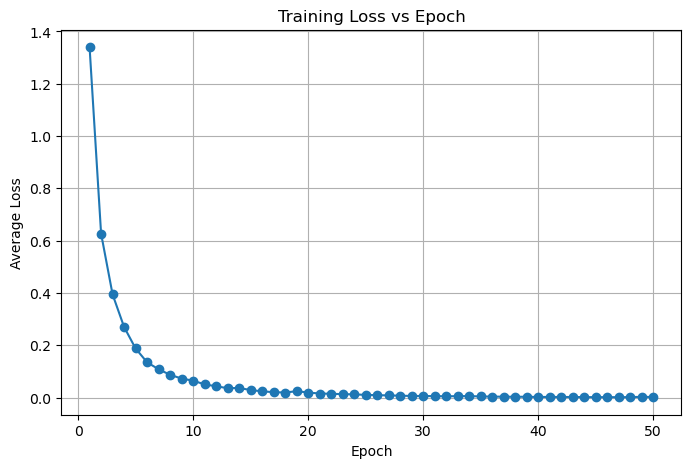

(60/60): Accuracy=0.95000


In [9]:
import os, io, torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
import numpy as np


def print_named_params(model):
  for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")


def load_filepaths(target_dir): 
  paths = []
  files = os.listdir(target_dir)
  for file in files:
    paths.append(f"{target_dir}/{file}")
  return paths


def prepare_data(target_dir):
    filepaths = []
    encoded_labels = []
    
    fpaths = load_filepaths(target_dir)
    
    for file in fpaths:
        if 'apple' in file:
            encoded_labels.append(0)
        elif 'banana' in file:
            encoded_labels.append(1)
        elif 'orange' in file:
            encoded_labels.append(2)
        else:
            encoded_labels.append(3)
            
    filepaths += fpaths
    
    return np.array(filepaths), torch.tensor(encoded_labels)
    


def load_images_train(filepaths):
  # Instantiate class to transform image to tensor
  transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor = None

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    img_tensor = transform(image)

    if tensor is None:
      tensor = img_tensor.unsqueeze(0)  # First image
    else:
      tensor = torch.cat((tensor, img_tensor.unsqueeze(0)), dim=0)

  return tensor  # ✅ Correctly indented inside the function

def load_images_test(filepaths):
  transform = transforms.Compose([
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor_list = []

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    tensor_list.append(transform(image))

  return torch.stack(tensor_list)


class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # in_channels=1 because our image is grayscale (if color images, then in_channels=3 for RGB).
    # out_channels=16 means we have 16 filters, each filter of size 3x3x1.
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    
    # in_channels=16 because our out_channels=16 from previous layer.
    # out_channels=32 means we are using 32 filters, each filter of size 3x3x16,
    # in this layer.
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

    # in_channels=32 because our out_channels=32 from previous layer.
    # out_channels=64 means we are using 64 filters, each filter of size 3x3x32,
    # in this layer.
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    
    # Max Pooling Layer: downsample by a factor of 2.
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Fully Connected Layer 1: input size = 7 * 7 * 32 (from feature maps), output size = 128.
    self.fc1 = nn.Linear(in_features= 64 * 8 * 8, out_features=128)
    
    self.dropout = nn.Dropout(p=0.5)  # Dropout with 50% probability

    
    # Fully Connected Layer 2: input size = 128, output size = 10 (for 10 output classes).
    self.fc2 = nn.Linear(in_features=128, out_features=4)

    # Activation function
    self.relu = nn.ReLU()

  def forward(self, x):
    #print(f"x.shape={x.shape}\n")

    # Apply convolution + ReLU + pooling
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)
    
    x = self.conv3(x)
    x = self.relu(x)
    x = self.pool(x)

    # Flatten the feature maps 
    x = x.view(x.size(0), -1)

    # Fully connected layers
    x = self.fc1(x)
    x = self.relu(x)
    
    x = self.dropout(x) # apply dropout during training

    
    # Output layer (no activation since we apply softmax in the loss function)
    x = self.fc2(x)    
    
    return x


def test(model, filepaths, labels):
  batch_size = 64
  samples_tested = 0
  correct_preds = 0
  total_samples = len(filepaths)

  for i in range(0, total_samples, batch_size):
    batch_inputs = load_images_test(filepaths[i : i + batch_size])
    batch_labels = labels[i : i + batch_size]

    # Forward pass: coyympute predicted outputs
    outputs = model(batch_inputs)

    # Get probability-distributions
    probs = torch.softmax(outputs, dim=1)
    _, preds = torch.max(probs, dim=1)

    # Determine accuracy
    samples_tested += len(batch_labels)
    correct_preds += torch.sum(preds == batch_labels)
    accuracy = correct_preds / float(samples_tested)

    print(f"({samples_tested}/{total_samples}): Accuracy={accuracy:.5f}")


def train(model, criterion, optimizer, filepaths, labels):
    # our hyper-parameters for training
    n_epochs = 50
    batch_size = 64
    batch_count = 0
    epoch_losses = []

    for epoch in range(n_epochs):
        # For tracking and printing our training-progress
        samples_trained = 0
        run_loss = 0
        correct_preds = 0
        total_samples = len(filepaths) 

        permutation = torch.randperm(total_samples)
        for i in range(0, total_samples, batch_size):
            indices = permutation[i : i+batch_size]
            batch_inputs = load_images_train(filepaths[indices])
            batch_labels = labels[indices]

            # Forward pass: compute predicted outputs
            outputs = model(batch_inputs)

            # Compute loss
            loss = criterion(outputs, batch_labels)
            run_loss += loss.item()
            batch_count += 1

            # Backward pass and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
      
            # Get probability-distributions
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, dim=1)
            

        # Calculate some stats
        # samples_trained += len(indices)
        samples_trained += len(batch_labels)
        avg_loss = run_loss / batch_count
        epoch_losses.append(avg_loss)

        correct_preds += torch.sum(preds == batch_labels) # compare predictions with labels
        accuracy = correct_preds / float(samples_trained) # cast to float to get "accuracy" in decimal 

        print(f"Epoch {epoch+1} " +
            f"({samples_trained}/{total_samples}): " +
            f"Loss={avg_loss:.5f}, Accuracy={accuracy:.5f}")

    return epoch_losses

# Instantiate the model, define the loss function and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model 
dir_train = "C:/Users/Admin/OneDrive/Desktop/train" # place accordingly
filepaths, labels = prepare_data(dir_train)
loss_history = train(model, criterion, optimizer, filepaths, labels)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
plt.title("Training Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()

# Test the model
dir_test = "C:/Users/Admin/OneDrive/Desktop/test"
filepaths, labels = prepare_data(dir_test)
test(model, filepaths, labels)



Epoch 1 (48/240): Loss=1.32444, Accuracy=0.35417
Epoch 2 (48/240): Loss=0.63882, Accuracy=0.35417
Epoch 3 (48/240): Loss=0.39244, Accuracy=0.56250
Epoch 4 (48/240): Loss=0.25790, Accuracy=0.68750
Epoch 5 (48/240): Loss=0.17589, Accuracy=0.64583
Epoch 6 (48/240): Loss=0.13729, Accuracy=0.66667
Epoch 7 (48/240): Loss=0.11339, Accuracy=0.60417
Epoch 8 (48/240): Loss=0.08691, Accuracy=0.72917
Epoch 9 (48/240): Loss=0.06895, Accuracy=0.85417
Epoch 10 (48/240): Loss=0.06241, Accuracy=0.79167
Epoch 11 (48/240): Loss=0.05343, Accuracy=0.79167
Epoch 12 (48/240): Loss=0.04429, Accuracy=0.81250
Epoch 13 (48/240): Loss=0.03870, Accuracy=0.79167
Epoch 14 (48/240): Loss=0.03341, Accuracy=0.87500
Epoch 15 (48/240): Loss=0.02879, Accuracy=0.85417
Epoch 16 (48/240): Loss=0.02570, Accuracy=0.83333
Epoch 17 (48/240): Loss=0.02427, Accuracy=0.89583
Epoch 18 (48/240): Loss=0.02185, Accuracy=0.93750
Epoch 19 (48/240): Loss=0.01879, Accuracy=0.87500
Epoch 20 (48/240): Loss=0.01644, Accuracy=0.85417


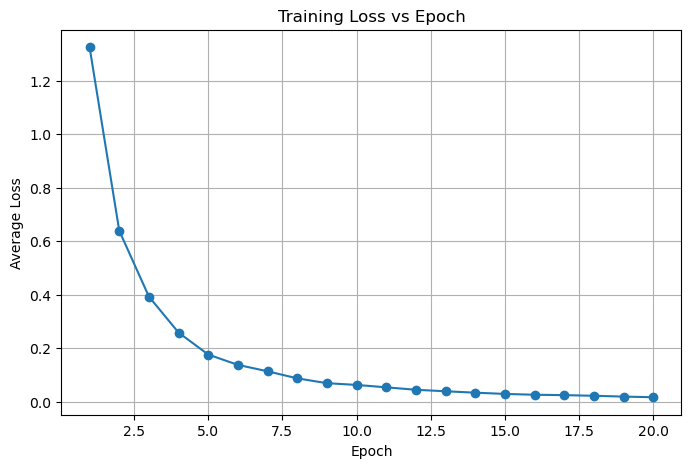

(60/60): Accuracy=0.83333


In [25]:
import os, io, torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
import numpy as np


def print_named_params(model):
  for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")


def load_filepaths(target_dir): 
  paths = []
  files = os.listdir(target_dir)
  for file in files:
    paths.append(f"{target_dir}/{file}")
  return paths


def prepare_data(target_dir):
    filepaths = []
    encoded_labels = []
    
    fpaths = load_filepaths(target_dir)
    
    for file in fpaths:
        if 'apple' in file:
            encoded_labels.append(0)
        elif 'banana' in file:
            encoded_labels.append(1)
        elif 'orange' in file:
            encoded_labels.append(2)
        else:
            encoded_labels.append(3)
            
    filepaths += fpaths
    
    return np.array(filepaths), torch.tensor(encoded_labels)
    


def load_images_train(filepaths):
  # Instantiate class to transform image to tensor
  transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor = None

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    img_tensor = transform(image)

    if tensor is None:
      tensor = img_tensor.unsqueeze(0)  # First image
    else:
      tensor = torch.cat((tensor, img_tensor.unsqueeze(0)), dim=0)

  return tensor  # ✅ Correctly indented inside the function

def load_images_test(filepaths):
  transform = transforms.Compose([
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor_list = []

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    tensor_list.append(transform(image))

  return torch.stack(tensor_list)


class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # in_channels=1 because our image is grayscale (if color images, then in_channels=3 for RGB).
    # out_channels=16 means we have 16 filters, each filter of size 3x3x1.
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    
    # in_channels=16 because our out_channels=16 from previous layer.
    # out_channels=32 means we are using 32 filters, each filter of size 3x3x16,
    # in this layer.
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

    # in_channels=32 because our out_channels=32 from previous layer.
    # out_channels=64 means we are using 64 filters, each filter of size 3x3x32,
    # in this layer.
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    
    # Max Pooling Layer: downsample by a factor of 2.
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Fully Connected Layer 1: input size = 7 * 7 * 32 (from feature maps), output size = 128.
    self.fc1 = nn.Linear(in_features= 64 * 8 * 8, out_features=128)
    
    self.dropout = nn.Dropout(p=0.5)  # Dropout with 50% probability

    
    # Fully Connected Layer 2: input size = 128, output size = 10 (for 10 output classes).
    self.fc2 = nn.Linear(in_features=128, out_features=4)

    # Activation function
    self.relu = nn.ReLU()

  def forward(self, x):
    #print(f"x.shape={x.shape}\n")

    # Apply convolution + ReLU + pooling
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)
    
    x = self.conv3(x)
    x = self.relu(x)
    x = self.pool(x)

    # Flatten the feature maps 
    x = x.view(x.size(0), -1)

    # Fully connected layers
    x = self.fc1(x)
    x = self.relu(x)
    
    x = self.dropout(x) # apply dropout during training

    
    # Output layer (no activation since we apply softmax in the loss function)
    x = self.fc2(x)    
    
    return x


def test(model, filepaths, labels):
  batch_size = 64
  samples_tested = 0
  correct_preds = 0
  total_samples = len(filepaths)

  for i in range(0, total_samples, batch_size):
    batch_inputs = load_images_test(filepaths[i : i + batch_size])
    batch_labels = labels[i : i + batch_size]

    # Forward pass: coyympute predicted outputs
    outputs = model(batch_inputs)

    # Get probability-distributions
    probs = torch.softmax(outputs, dim=1)
    _, preds = torch.max(probs, dim=1)

    # Determine accuracy
    samples_tested += len(batch_labels)
    correct_preds += torch.sum(preds == batch_labels)
    accuracy = correct_preds / float(samples_tested)

    print(f"({samples_tested}/{total_samples}): Accuracy={accuracy:.5f}")


def train(model, criterion, optimizer, filepaths, labels):
    # our hyper-parameters for training
    n_epochs = 20
    batch_size = 64
    batch_count = 0
    epoch_losses = []

    for epoch in range(n_epochs):
        # For tracking and printing our training-progress
        samples_trained = 0
        run_loss = 0
        correct_preds = 0
        total_samples = len(filepaths) 

        permutation = torch.randperm(total_samples)
        for i in range(0, total_samples, batch_size):
            indices = permutation[i : i+batch_size]
            batch_inputs = load_images_train(filepaths[indices])
            batch_labels = labels[indices]

            # Forward pass: compute predicted outputs
            outputs = model(batch_inputs)

            # Compute loss
            loss = criterion(outputs, batch_labels)
            run_loss += loss.item()
            batch_count += 1

            # Backward pass and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
      
            # Get probability-distributions
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, dim=1)
            

        # Calculate some stats
        # samples_trained += len(indices)
        samples_trained += len(batch_labels)
        avg_loss = run_loss / batch_count
        epoch_losses.append(avg_loss)

        correct_preds += torch.sum(preds == batch_labels) # compare predictions with labels
        accuracy = correct_preds / float(samples_trained) # cast to float to get "accuracy" in decimal 

        print(f"Epoch {epoch+1} " +
            f"({samples_trained}/{total_samples}): " +
            f"Loss={avg_loss:.5f}, Accuracy={accuracy:.5f}")

    return epoch_losses

# Instantiate the model, define the loss function and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model 
dir_train = "C:/Users/Admin/OneDrive/Desktop/train" # place accordingly
filepaths, labels = prepare_data(dir_train)
loss_history = train(model, criterion, optimizer, filepaths, labels)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
plt.title("Training Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()

# Test the model
dir_test = "C:/Users/Admin/OneDrive/Desktop/test"
filepaths, labels = prepare_data(dir_test)
test(model, filepaths, labels)

Epoch 1 (48/240): Loss=1.34986, Accuracy=0.22917
Epoch 2 (48/240): Loss=0.64499, Accuracy=0.41667
Epoch 3 (48/240): Loss=0.39490, Accuracy=0.58333
Epoch 4 (48/240): Loss=0.25066, Accuracy=0.62500
Epoch 5 (48/240): Loss=0.16933, Accuracy=0.72917
Epoch 6 (48/240): Loss=0.11845, Accuracy=0.77083
Epoch 7 (48/240): Loss=0.09568, Accuracy=0.70833
Epoch 8 (48/240): Loss=0.07477, Accuracy=0.79167
Epoch 9 (48/240): Loss=0.05907, Accuracy=0.83333
Epoch 10 (48/240): Loss=0.04244, Accuracy=0.87500
Epoch 11 (48/240): Loss=0.03856, Accuracy=0.83333
Epoch 12 (48/240): Loss=0.03398, Accuracy=0.77083
Epoch 13 (48/240): Loss=0.02738, Accuracy=0.87500
Epoch 14 (48/240): Loss=0.02555, Accuracy=0.81250
Epoch 15 (48/240): Loss=0.02962, Accuracy=0.70833
Epoch 16 (48/240): Loss=0.01852, Accuracy=0.95833
Epoch 17 (48/240): Loss=0.01503, Accuracy=0.93750
Epoch 18 (48/240): Loss=0.01408, Accuracy=0.89583
Epoch 19 (48/240): Loss=0.01206, Accuracy=0.91667
Epoch 20 (48/240): Loss=0.01057, Accuracy=0.91667
Epoch 21 

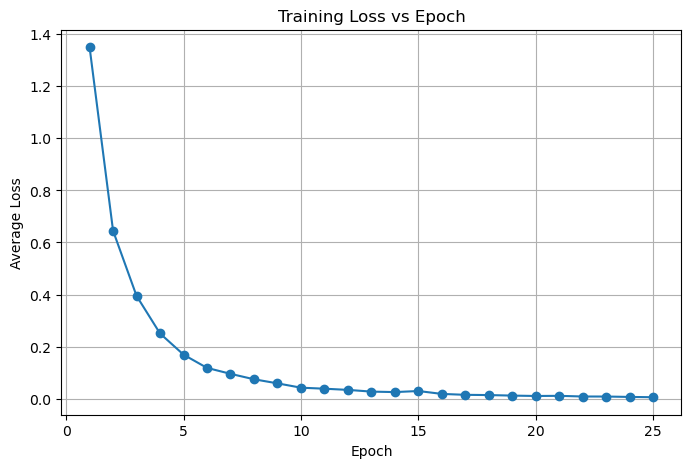

(60/60): Accuracy=0.90000


In [26]:
import os, io, torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
import numpy as np


def print_named_params(model):
  for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")


def load_filepaths(target_dir): 
  paths = []
  files = os.listdir(target_dir)
  for file in files:
    paths.append(f"{target_dir}/{file}")
  return paths


def prepare_data(target_dir):
    filepaths = []
    encoded_labels = []
    
    fpaths = load_filepaths(target_dir)
    
    for file in fpaths:
        if 'apple' in file:
            encoded_labels.append(0)
        elif 'banana' in file:
            encoded_labels.append(1)
        elif 'orange' in file:
            encoded_labels.append(2)
        else:
            encoded_labels.append(3)
            
    filepaths += fpaths
    
    return np.array(filepaths), torch.tensor(encoded_labels)
    


def load_images_train(filepaths):
  # Instantiate class to transform image to tensor
  transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor = None

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    img_tensor = transform(image)

    if tensor is None:
      tensor = img_tensor.unsqueeze(0)  # First image
    else:
      tensor = torch.cat((tensor, img_tensor.unsqueeze(0)), dim=0)

  return tensor  # ✅ Correctly indented inside the function

def load_images_test(filepaths):
  transform = transforms.Compose([
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor_list = []

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    tensor_list.append(transform(image))

  return torch.stack(tensor_list)


class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # in_channels=1 because our image is grayscale (if color images, then in_channels=3 for RGB).
    # out_channels=16 means we have 16 filters, each filter of size 3x3x1.
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    
    # in_channels=16 because our out_channels=16 from previous layer.
    # out_channels=32 means we are using 32 filters, each filter of size 3x3x16,
    # in this layer.
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

    # in_channels=32 because our out_channels=32 from previous layer.
    # out_channels=64 means we are using 64 filters, each filter of size 3x3x32,
    # in this layer.
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    
    # Max Pooling Layer: downsample by a factor of 2.
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Fully Connected Layer 1: input size = 7 * 7 * 32 (from feature maps), output size = 128.
    self.fc1 = nn.Linear(in_features= 64 * 8 * 8, out_features=128)
    
    self.dropout = nn.Dropout(p=0.5)  # Dropout with 50% probability

    
    # Fully Connected Layer 2: input size = 128, output size = 10 (for 10 output classes).
    self.fc2 = nn.Linear(in_features=128, out_features=4)

    # Activation function
    self.relu = nn.ReLU()

  def forward(self, x):
    #print(f"x.shape={x.shape}\n")

    # Apply convolution + ReLU + pooling
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)
    
    x = self.conv3(x)
    x = self.relu(x)
    x = self.pool(x)

    # Flatten the feature maps 
    x = x.view(x.size(0), -1)

    # Fully connected layers
    x = self.fc1(x)
    x = self.relu(x)
    
    x = self.dropout(x) # apply dropout during training

    
    # Output layer (no activation since we apply softmax in the loss function)
    x = self.fc2(x)    
    
    return x


def test(model, filepaths, labels):
  batch_size = 64
  samples_tested = 0
  correct_preds = 0
  total_samples = len(filepaths)

  for i in range(0, total_samples, batch_size):
    batch_inputs = load_images_test(filepaths[i : i + batch_size])
    batch_labels = labels[i : i + batch_size]

    # Forward pass: coyympute predicted outputs
    outputs = model(batch_inputs)

    # Get probability-distributions
    probs = torch.softmax(outputs, dim=1)
    _, preds = torch.max(probs, dim=1)

    # Determine accuracy
    samples_tested += len(batch_labels)
    correct_preds += torch.sum(preds == batch_labels)
    accuracy = correct_preds / float(samples_tested)

    print(f"({samples_tested}/{total_samples}): Accuracy={accuracy:.5f}")


def train(model, criterion, optimizer, filepaths, labels):
    # our hyper-parameters for training
    n_epochs = 25
    batch_size = 64
    batch_count = 0
    epoch_losses = []

    for epoch in range(n_epochs):
        # For tracking and printing our training-progress
        samples_trained = 0
        run_loss = 0
        correct_preds = 0
        total_samples = len(filepaths) 

        permutation = torch.randperm(total_samples)
        for i in range(0, total_samples, batch_size):
            indices = permutation[i : i+batch_size]
            batch_inputs = load_images_train(filepaths[indices])
            batch_labels = labels[indices]

            # Forward pass: compute predicted outputs
            outputs = model(batch_inputs)

            # Compute loss
            loss = criterion(outputs, batch_labels)
            run_loss += loss.item()
            batch_count += 1

            # Backward pass and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
      
            # Get probability-distributions
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, dim=1)
            

        # Calculate some stats
        # samples_trained += len(indices)
        samples_trained += len(batch_labels)
        avg_loss = run_loss / batch_count
        epoch_losses.append(avg_loss)

        correct_preds += torch.sum(preds == batch_labels) # compare predictions with labels
        accuracy = correct_preds / float(samples_trained) # cast to float to get "accuracy" in decimal 

        print(f"Epoch {epoch+1} " +
            f"({samples_trained}/{total_samples}): " +
            f"Loss={avg_loss:.5f}, Accuracy={accuracy:.5f}")

    return epoch_losses

# Instantiate the model, define the loss function and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model 
dir_train = "C:/Users/Admin/OneDrive/Desktop/train" # place accordingly
filepaths, labels = prepare_data(dir_train)
loss_history = train(model, criterion, optimizer, filepaths, labels)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
plt.title("Training Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()

# Test the model
dir_test = "C:/Users/Admin/OneDrive/Desktop/test"
filepaths, labels = prepare_data(dir_test)
test(model, filepaths, labels)

Epoch 1 (48/240): Loss=1.35017, Accuracy=0.27083
Epoch 2 (48/240): Loss=0.65815, Accuracy=0.29167
Epoch 3 (48/240): Loss=0.41154, Accuracy=0.39583
Epoch 4 (48/240): Loss=0.28545, Accuracy=0.66667
Epoch 5 (48/240): Loss=0.20147, Accuracy=0.66667
Epoch 6 (48/240): Loss=0.15203, Accuracy=0.68750
Epoch 7 (48/240): Loss=0.11722, Accuracy=0.85417
Epoch 8 (48/240): Loss=0.07799, Accuracy=0.87500
Epoch 9 (48/240): Loss=0.06405, Accuracy=0.83333
Epoch 10 (48/240): Loss=0.04977, Accuracy=0.79167
Epoch 11 (48/240): Loss=0.04233, Accuracy=0.79167
Epoch 12 (48/240): Loss=0.03131, Accuracy=0.89583
Epoch 13 (48/240): Loss=0.03201, Accuracy=0.75000
Epoch 14 (48/240): Loss=0.02609, Accuracy=0.87500
Epoch 15 (48/240): Loss=0.02356, Accuracy=0.93750
Epoch 16 (48/240): Loss=0.02109, Accuracy=0.83333
Epoch 17 (48/240): Loss=0.01912, Accuracy=0.87500
Epoch 18 (48/240): Loss=0.01490, Accuracy=0.93750
Epoch 19 (48/240): Loss=0.01533, Accuracy=0.87500
Epoch 20 (48/240): Loss=0.01339, Accuracy=0.89583
Epoch 21 

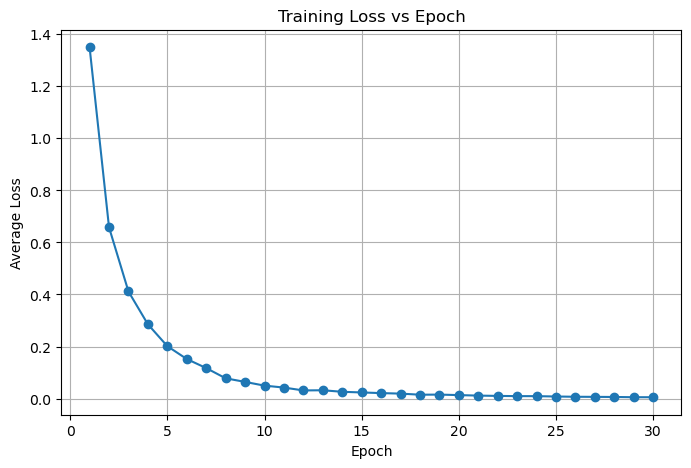

(60/60): Accuracy=0.90000


In [27]:
import os, io, torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
import numpy as np


def print_named_params(model):
  for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")


def load_filepaths(target_dir): 
  paths = []
  files = os.listdir(target_dir)
  for file in files:
    paths.append(f"{target_dir}/{file}")
  return paths


def prepare_data(target_dir):
    filepaths = []
    encoded_labels = []
    
    fpaths = load_filepaths(target_dir)
    
    for file in fpaths:
        if 'apple' in file:
            encoded_labels.append(0)
        elif 'banana' in file:
            encoded_labels.append(1)
        elif 'orange' in file:
            encoded_labels.append(2)
        else:
            encoded_labels.append(3)
            
    filepaths += fpaths
    
    return np.array(filepaths), torch.tensor(encoded_labels)
    


def load_images_train(filepaths):
  # Instantiate class to transform image to tensor
  transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor = None

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    img_tensor = transform(image)

    if tensor is None:
      tensor = img_tensor.unsqueeze(0)  # First image
    else:
      tensor = torch.cat((tensor, img_tensor.unsqueeze(0)), dim=0)

  return tensor  # ✅ Correctly indented inside the function

def load_images_test(filepaths):
  transform = transforms.Compose([
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor_list = []

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    tensor_list.append(transform(image))

  return torch.stack(tensor_list)


class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # in_channels=1 because our image is grayscale (if color images, then in_channels=3 for RGB).
    # out_channels=16 means we have 16 filters, each filter of size 3x3x1.
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    
    # in_channels=16 because our out_channels=16 from previous layer.
    # out_channels=32 means we are using 32 filters, each filter of size 3x3x16,
    # in this layer.
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

    # in_channels=32 because our out_channels=32 from previous layer.
    # out_channels=64 means we are using 64 filters, each filter of size 3x3x32,
    # in this layer.
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    
    # Max Pooling Layer: downsample by a factor of 2.
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Fully Connected Layer 1: input size = 7 * 7 * 32 (from feature maps), output size = 128.
    self.fc1 = nn.Linear(in_features= 64 * 8 * 8, out_features=128)
    
    self.dropout = nn.Dropout(p=0.5)  # Dropout with 50% probability

    
    # Fully Connected Layer 2: input size = 128, output size = 10 (for 10 output classes).
    self.fc2 = nn.Linear(in_features=128, out_features=4)

    # Activation function
    self.relu = nn.ReLU()

  def forward(self, x):
    #print(f"x.shape={x.shape}\n")

    # Apply convolution + ReLU + pooling
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)
    
    x = self.conv3(x)
    x = self.relu(x)
    x = self.pool(x)

    # Flatten the feature maps 
    x = x.view(x.size(0), -1)

    # Fully connected layers
    x = self.fc1(x)
    x = self.relu(x)
    
    x = self.dropout(x) # apply dropout during training

    
    # Output layer (no activation since we apply softmax in the loss function)
    x = self.fc2(x)    
    
    return x


def test(model, filepaths, labels):
  batch_size = 64
  samples_tested = 0
  correct_preds = 0
  total_samples = len(filepaths)

  for i in range(0, total_samples, batch_size):
    batch_inputs = load_images_test(filepaths[i : i + batch_size])
    batch_labels = labels[i : i + batch_size]

    # Forward pass: coyympute predicted outputs
    outputs = model(batch_inputs)

    # Get probability-distributions
    probs = torch.softmax(outputs, dim=1)
    _, preds = torch.max(probs, dim=1)

    # Determine accuracy
    samples_tested += len(batch_labels)
    correct_preds += torch.sum(preds == batch_labels)
    accuracy = correct_preds / float(samples_tested)

    print(f"({samples_tested}/{total_samples}): Accuracy={accuracy:.5f}")


def train(model, criterion, optimizer, filepaths, labels):
    # our hyper-parameters for training
    n_epochs = 30
    batch_size = 64
    batch_count = 0
    epoch_losses = []

    for epoch in range(n_epochs):
        # For tracking and printing our training-progress
        samples_trained = 0
        run_loss = 0
        correct_preds = 0
        total_samples = len(filepaths) 

        permutation = torch.randperm(total_samples)
        for i in range(0, total_samples, batch_size):
            indices = permutation[i : i+batch_size]
            batch_inputs = load_images_train(filepaths[indices])
            batch_labels = labels[indices]

            # Forward pass: compute predicted outputs
            outputs = model(batch_inputs)

            # Compute loss
            loss = criterion(outputs, batch_labels)
            run_loss += loss.item()
            batch_count += 1

            # Backward pass and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
      
            # Get probability-distributions
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, dim=1)
            

        # Calculate some stats
        # samples_trained += len(indices)
        samples_trained += len(batch_labels)
        avg_loss = run_loss / batch_count
        epoch_losses.append(avg_loss)

        correct_preds += torch.sum(preds == batch_labels) # compare predictions with labels
        accuracy = correct_preds / float(samples_trained) # cast to float to get "accuracy" in decimal 

        print(f"Epoch {epoch+1} " +
            f"({samples_trained}/{total_samples}): " +
            f"Loss={avg_loss:.5f}, Accuracy={accuracy:.5f}")

    return epoch_losses

# Instantiate the model, define the loss function and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model 
dir_train = "C:/Users/Admin/OneDrive/Desktop/train" # place accordingly
filepaths, labels = prepare_data(dir_train)
loss_history = train(model, criterion, optimizer, filepaths, labels)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
plt.title("Training Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()

# Test the model
dir_test = "C:/Users/Admin/OneDrive/Desktop/test"
filepaths, labels = prepare_data(dir_test)
test(model, filepaths, labels)

Epoch 1 (48/240): Loss=1.37350, Accuracy=0.22917
Epoch 2 (48/240): Loss=0.66932, Accuracy=0.20833
Epoch 3 (48/240): Loss=0.43105, Accuracy=0.41667
Epoch 4 (48/240): Loss=0.31835, Accuracy=0.33333
Epoch 5 (48/240): Loss=0.25011, Accuracy=0.52083
Epoch 6 (48/240): Loss=0.20022, Accuracy=0.54167
Epoch 7 (48/240): Loss=0.15869, Accuracy=0.58333
Epoch 8 (48/240): Loss=0.12596, Accuracy=0.62500
Epoch 9 (48/240): Loss=0.09675, Accuracy=0.79167
Epoch 10 (48/240): Loss=0.07304, Accuracy=0.79167
Epoch 11 (48/240): Loss=0.05888, Accuracy=0.83333
Epoch 12 (48/240): Loss=0.05408, Accuracy=0.72917
Epoch 13 (48/240): Loss=0.04389, Accuracy=0.83333
Epoch 14 (48/240): Loss=0.03766, Accuracy=0.77083
Epoch 15 (48/240): Loss=0.03411, Accuracy=0.77083
Epoch 16 (48/240): Loss=0.02860, Accuracy=0.89583
Epoch 17 (48/240): Loss=0.02665, Accuracy=0.89583
Epoch 18 (48/240): Loss=0.02398, Accuracy=0.87500
Epoch 19 (48/240): Loss=0.02227, Accuracy=0.85417
Epoch 20 (48/240): Loss=0.02326, Accuracy=0.83333
Epoch 21 

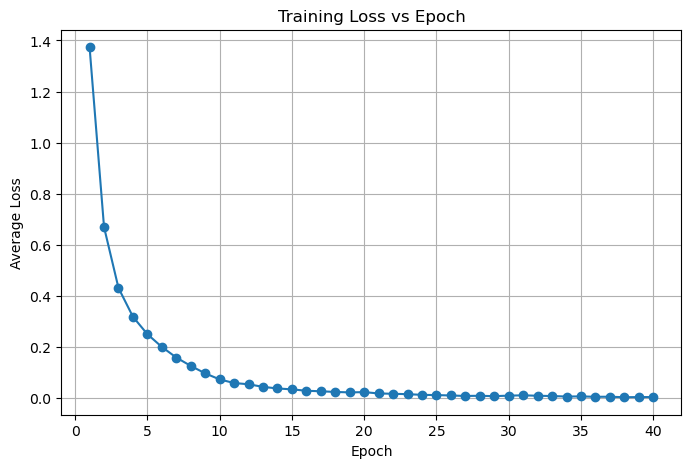

(60/60): Accuracy=0.90000


In [30]:
import os, io, torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
import numpy as np


def print_named_params(model):
  for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")


def load_filepaths(target_dir): 
  paths = []
  files = os.listdir(target_dir)
  for file in files:
    paths.append(f"{target_dir}/{file}")
  return paths


def prepare_data(target_dir):
    filepaths = []
    encoded_labels = []
    
    fpaths = load_filepaths(target_dir)
    
    for file in fpaths:
        if 'apple' in file:
            encoded_labels.append(0)
        elif 'banana' in file:
            encoded_labels.append(1)
        elif 'orange' in file:
            encoded_labels.append(2)
        else:
            encoded_labels.append(3)
            
    filepaths += fpaths
    
    return np.array(filepaths), torch.tensor(encoded_labels)
    


def load_images_train(filepaths):
  # Instantiate class to transform image to tensor
  transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor = None

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    img_tensor = transform(image)

    if tensor is None:
      tensor = img_tensor.unsqueeze(0)  # First image
    else:
      tensor = torch.cat((tensor, img_tensor.unsqueeze(0)), dim=0)

  return tensor  # ✅ Correctly indented inside the function

def load_images_test(filepaths):
  transform = transforms.Compose([
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor_list = []

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    tensor_list.append(transform(image))

  return torch.stack(tensor_list)


class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # in_channels=1 because our image is grayscale (if color images, then in_channels=3 for RGB).
    # out_channels=16 means we have 16 filters, each filter of size 3x3x1.
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    
    # in_channels=16 because our out_channels=16 from previous layer.
    # out_channels=32 means we are using 32 filters, each filter of size 3x3x16,
    # in this layer.
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

    # in_channels=32 because our out_channels=32 from previous layer.
    # out_channels=64 means we are using 64 filters, each filter of size 3x3x32,
    # in this layer.
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    
    # Max Pooling Layer: downsample by a factor of 2.
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Fully Connected Layer 1: input size = 7 * 7 * 32 (from feature maps), output size = 128.
    self.fc1 = nn.Linear(in_features= 64 * 8 * 8, out_features=128)
    
    self.dropout = nn.Dropout(p=0.5)  # Dropout with 50% probability

    
    # Fully Connected Layer 2: input size = 128, output size = 10 (for 10 output classes).
    self.fc2 = nn.Linear(in_features=128, out_features=4)

    # Activation function
    self.relu = nn.ReLU()

  def forward(self, x):
    #print(f"x.shape={x.shape}\n")

    # Apply convolution + ReLU + pooling
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)
    
    x = self.conv3(x)
    x = self.relu(x)
    x = self.pool(x)

    # Flatten the feature maps 
    x = x.view(x.size(0), -1)

    # Fully connected layers
    x = self.fc1(x)
    x = self.relu(x)
    
    x = self.dropout(x) # apply dropout during training

    
    # Output layer (no activation since we apply softmax in the loss function)
    x = self.fc2(x)    
    
    return x


def test(model, filepaths, labels):
  batch_size = 64
  samples_tested = 0
  correct_preds = 0
  total_samples = len(filepaths)

  for i in range(0, total_samples, batch_size):
    batch_inputs = load_images_test(filepaths[i : i + batch_size])
    batch_labels = labels[i : i + batch_size]

    # Forward pass: coyympute predicted outputs
    outputs = model(batch_inputs)

    # Get probability-distributions
    probs = torch.softmax(outputs, dim=1)
    _, preds = torch.max(probs, dim=1)

    # Determine accuracy
    samples_tested += len(batch_labels)
    correct_preds += torch.sum(preds == batch_labels)
    accuracy = correct_preds / float(samples_tested)

    print(f"({samples_tested}/{total_samples}): Accuracy={accuracy:.5f}")


def train(model, criterion, optimizer, filepaths, labels):
    # our hyper-parameters for training
    n_epochs = 40
    batch_size = 64
    batch_count = 0
    epoch_losses = []

    for epoch in range(n_epochs):
        # For tracking and printing our training-progress
        samples_trained = 0
        run_loss = 0
        correct_preds = 0
        total_samples = len(filepaths) 

        permutation = torch.randperm(total_samples)
        for i in range(0, total_samples, batch_size):
            indices = permutation[i : i+batch_size]
            batch_inputs = load_images_train(filepaths[indices])
            batch_labels = labels[indices]

            # Forward pass: compute predicted outputs
            outputs = model(batch_inputs)

            # Compute loss
            loss = criterion(outputs, batch_labels)
            run_loss += loss.item()
            batch_count += 1

            # Backward pass and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
      
            # Get probability-distributions
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, dim=1)
            

        # Calculate some stats
        # samples_trained += len(indices)
        samples_trained += len(batch_labels)
        avg_loss = run_loss / batch_count
        epoch_losses.append(avg_loss)

        correct_preds += torch.sum(preds == batch_labels) # compare predictions with labels
        accuracy = correct_preds / float(samples_trained) # cast to float to get "accuracy" in decimal 

        print(f"Epoch {epoch+1} " +
            f"({samples_trained}/{total_samples}): " +
            f"Loss={avg_loss:.5f}, Accuracy={accuracy:.5f}")

    return epoch_losses

# Instantiate the model, define the loss function and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model 
dir_train = "C:/Users/Admin/OneDrive/Desktop/train" # place accordingly
filepaths, labels = prepare_data(dir_train)
loss_history = train(model, criterion, optimizer, filepaths, labels)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
plt.title("Training Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()

# Test the model
dir_test = "C:/Users/Admin/OneDrive/Desktop/test"
filepaths, labels = prepare_data(dir_test)
test(model, filepaths, labels)

C:\Users\Admin\anaconda3\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1 (48/240): Loss=1.39079, Accuracy=0.29167
Epoch 2 (48/240): Loss=0.68097, Accuracy=0.43750
Epoch 3 (48/240): Loss=0.43387, Accuracy=0.64583
Epoch 4 (48/240): Loss=0.29813, Accuracy=0.54167
Epoch 5 (48/240): Loss=0.21962, Accuracy=0.62500
Epoch 6 (48/240): Loss=0.15896, Accuracy=0.66667
Epoch 7 (48/240): Loss=0.12565, Accuracy=0.64583
Epoch 8 (48/240): Loss=0.10050, Accuracy=0.70833
Epoch 9 (48/240): Loss=0.08015, Accuracy=0.77083
Epoch 10 (48/240): Loss=0.06569, Accuracy=0.72917
Epoch 11 (48/240): Loss=0.06290, Accuracy=0.68750
Epoch 12 (48/240): Loss=0.04997, Accuracy=0.75000
Epoch 13 (48/240): Loss=0.04438, Accuracy=0.79167
Epoch 14 (48/240): Loss=0.04385, Accuracy=0.87500
Epoch 15 (48/240): Loss=0.04821, Accuracy=0.70833
Epoch 16 (48/240): Loss=0.03893, Accuracy=0.79167
Epoch 17 (48/240): Loss=0.03230, Accuracy=0.85417
Epoch 18 (48/240): Loss=0.02604, Accuracy=0.85417
Epoch 19 (48/240): Loss=0.02077, Accuracy=0.89583
Epoch 20 (48/240): Loss=0.02058, Accuracy=0.89583
Epoch 21 

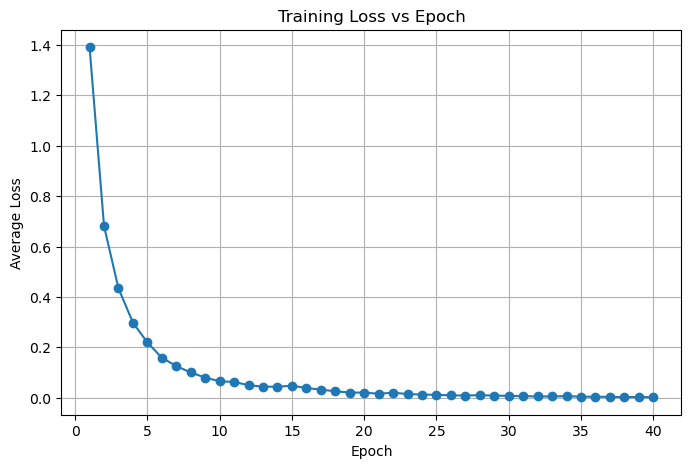

(60/60): Accuracy=0.88333


In [8]:
import os, io, torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight


def print_named_params(model):
  for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")


def load_filepaths(target_dir): 
  paths = []
  files = os.listdir(target_dir)
  for file in files:
    paths.append(f"{target_dir}/{file}")
  return paths


def prepare_data(target_dir):
    filepaths = []
    encoded_labels = []
    
    fpaths = load_filepaths(target_dir)
    
    for file in fpaths:
        if 'apple' in file:
            encoded_labels.append(0)
        elif 'banana' in file:
            encoded_labels.append(1)
        elif 'orange' in file:
            encoded_labels.append(2)
        else:
            encoded_labels.append(3)
            
    filepaths += fpaths
    
    return np.array(filepaths), torch.tensor(encoded_labels)
    


def load_images_train(filepaths):
  # Instantiate class to transform image to tensor
  transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor = None

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    img_tensor = transform(image)

    if tensor is None:
      tensor = img_tensor.unsqueeze(0)  # First image
    else:
      tensor = torch.cat((tensor, img_tensor.unsqueeze(0)), dim=0)

  return tensor  # ✅ Correctly indented inside the function

def load_images_test(filepaths):
  transform = transforms.Compose([
      transforms.Resize((64, 64)),
      transforms.ToTensor()
  ])

  tensor_list = []

  for item in filepaths:
    image = Image.open(item).convert("RGB")
    tensor_list.append(transform(image))

  return torch.stack(tensor_list)


class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # in_channels=1 because our image is grayscale (if color images, then in_channels=3 for RGB).
    # out_channels=16 means we have 16 filters, each filter of size 3x3x1.
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    
    # in_channels=16 because our out_channels=16 from previous layer.
    # out_channels=32 means we are using 32 filters, each filter of size 3x3x16,
    # in this layer.
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

    # in_channels=32 because our out_channels=32 from previous layer.
    # out_channels=64 means we are using 64 filters, each filter of size 3x3x32,
    # in this layer.
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    
    # Max Pooling Layer: downsample by a factor of 2.
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Fully Connected Layer 1: input size = 7 * 7 * 32 (from feature maps), output size = 128.
    self.fc1 = nn.Linear(in_features= 64 * 8 * 8, out_features=128)
    
    self.dropout = nn.Dropout(p=0.5)  # Dropout with 50% probability

    
    # Fully Connected Layer 2: input size = 128, output size = 10 (for 10 output classes).
    self.fc2 = nn.Linear(in_features=128, out_features=4)

    # Activation function
    self.relu = nn.ReLU()

  def forward(self, x):
    #print(f"x.shape={x.shape}\n")

    # Apply convolution + ReLU + pooling
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)
    
    x = self.conv3(x)
    x = self.relu(x)
    x = self.pool(x)

    # Flatten the feature maps 
    x = x.view(x.size(0), -1)

    # Fully connected layers
    x = self.fc1(x)
    x = self.relu(x)
    
    x = self.dropout(x) # apply dropout during training

    
    # Output layer (no activation since we apply softmax in the loss function)
    x = self.fc2(x)    
    
    return x


def test(model, filepaths, labels):
  batch_size = 64
  samples_tested = 0
  correct_preds = 0
  total_samples = len(filepaths)

  for i in range(0, total_samples, batch_size):
    batch_inputs = load_images_test(filepaths[i : i + batch_size])
    batch_labels = labels[i : i + batch_size]

    # Forward pass: coyympute predicted outputs
    outputs = model(batch_inputs)

    # Get probability-distributions
    probs = torch.softmax(outputs, dim=1)
    _, preds = torch.max(probs, dim=1)

    # Determine accuracy
    samples_tested += len(batch_labels)
    correct_preds += torch.sum(preds == batch_labels)
    accuracy = correct_preds / float(samples_tested)

    print(f"({samples_tested}/{total_samples}): Accuracy={accuracy:.5f}")


def train(model, criterion, optimizer, filepaths, labels):
    # our hyper-parameters for training
    n_epochs = 50
    batch_size = 64
    batch_count = 0
    epoch_losses = []

    for epoch in range(n_epochs):
        # For tracking and printing our training-progress
        samples_trained = 0
        run_loss = 0
        correct_preds = 0
        total_samples = len(filepaths) 

        permutation = torch.randperm(total_samples)
        for i in range(0, total_samples, batch_size):
            indices = permutation[i : i+batch_size]
            batch_inputs = load_images_train(filepaths[indices])
            batch_labels = labels[indices]

            # Forward pass: compute predicted outputs
            outputs = model(batch_inputs)

            # Compute loss
            loss = criterion(outputs, batch_labels)
            run_loss += loss.item()
            batch_count += 1

            # Backward pass and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
      
            # Get probability-distributions
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, dim=1)
            

        # Calculate some stats
        # samples_trained += len(indices)
        samples_trained += len(batch_labels)
        avg_loss = run_loss / batch_count
        epoch_losses.append(avg_loss)

        correct_preds += torch.sum(preds == batch_labels) # compare predictions with labels
        accuracy = correct_preds / float(samples_trained) # cast to float to get "accuracy" in decimal 

        print(f"Epoch {epoch+1} " +
            f"({samples_trained}/{total_samples}): " +
            f"Loss={avg_loss:.5f}, Accuracy={accuracy:.5f}")

    return epoch_losses




# Instantiate the model, define the loss function and optimizer
model = SimpleCNN()

# Train the model 
dir_train = "C:/Users/Admin/OneDrive/Desktop/train" # place accordingly
filepaths, labels = prepare_data(dir_train)

# Convert tensor to numpy array
labels_np = labels.numpy()
classes = np.unique(labels_np)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels_np)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Apply weights to CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_history = train(model, criterion, optimizer, filepaths, labels)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
plt.title("Training Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()

# Test the model
dir_test = "C:/Users/Admin/OneDrive/Desktop/test"
filepaths, labels = prepare_data(dir_test)
test(model, filepaths, labels)